step 1 do camera calibration

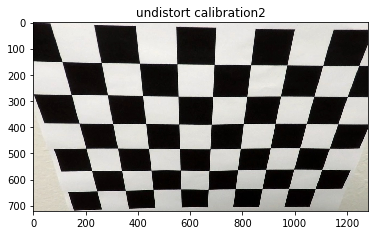

In [233]:
# %pylab inline
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

#test out undistort image 
img = cv2.imread("camera_cal/calibration1.jpg")
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

img = cv2.imread("camera_cal/calibration2.jpg")
img_undisort = cv2.undistort(img, mtx, dist, None, mtx)
plt.title("undistort calibration2")
plt.imshow(cv2.cvtColor(img_undisort,cv2.COLOR_BGR2RGB))
plt.show()



step 2:test out undistort image and perfom perspective transform
step 3: filter out bird eye view lane line based on color space (white and yellow)

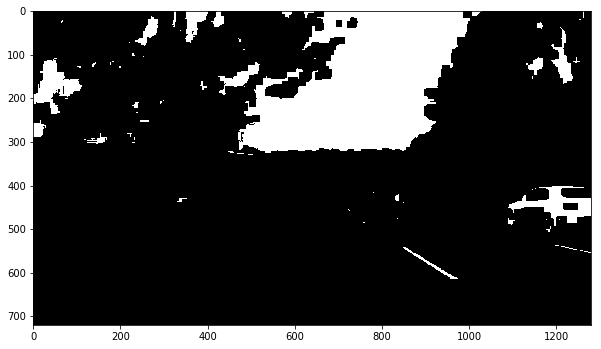

<function __main__.interactive_mask>

In [234]:
from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display
import cv2

image = cv2.imread('test_images/test5.jpg')
undistort_image = cv2.undistort(image, mtx, dist, None, mtx)

def abs_sobel_thresh(img, orient='x', thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thres=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thres[0]) & (gradmag <= mag_thres[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output



def thresh(img, thresh_min, thresh_max):
        ret = np.zeros_like(img)
        ret[(img >= thresh_min) & (img <= thresh_max)] = 1
        return ret

def combined_binary_mask(img, ksize, mag_low, mag_high, dir_low, dir_high,\
                                    hls_low, hls_high, bright_low, bright_high):
    kernel = np.ones((ksize, ksize), np.uint8)
    img = cv2.morphologyEx(img.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    
    b = np.zeros((img.shape[0],img.shape[1]))
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = hsv[:,:,0]
    S = hsv[:,:,1]
    V = hsv[:,:,2]

    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]

    t_yellow_H = thresh(H,10,30)
    t_yellow_S = thresh(S,50,255)
    t_yellow_V = thresh(V,150,255)

    t_white_R = thresh(R,225,255)
    t_white_V = thresh(V,230,255)
    
    dir_binary = dir_threshold(img,ksize, (dir_low, dir_high))
    mag_binary = mag_thresh(img, ksize, (mag_low, mag_high))

    b[(t_yellow_H==1) & (t_yellow_S==1) & (t_yellow_V==1)] = 1
    b[(t_white_R + t_white_V + dir_binary + mag_binary) >= 2] = 1
    
    return b
    
def interactive_mask(ksize, mag_low, mag_high, dir_low, dir_high, hls_low, hls_high, bright_low, bright_high):
    combined = combined_binary_mask(image, ksize, mag_low, mag_high, dir_low, dir_high,\
                                    hls_low, hls_high, bright_low, bright_high)
    plt.figure(figsize=(10,10))
    plt.imshow(combined,cmap='gray')
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

interact(interactive_mask, ksize=(1,31,2), mag_low=(0,255), mag_high=(0,255),\
         dir_low=(0, np.pi/2), dir_high=(0, np.pi/2), hls_low=(0,255),\
         hls_high=(0,255), bright_low=(0,255), bright_high=(0,255))



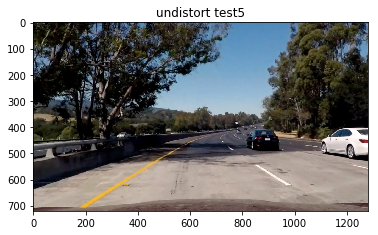

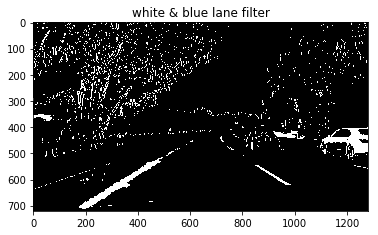

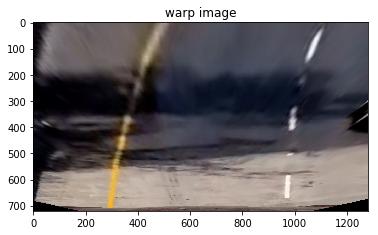

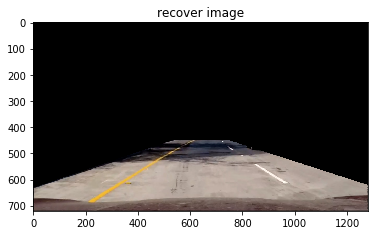

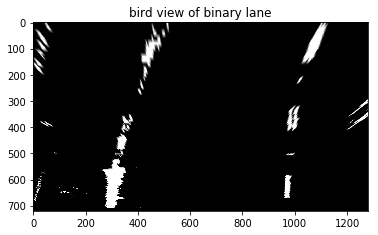

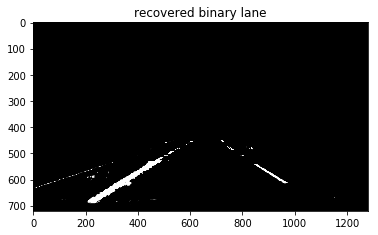

In [235]:
#apply to test images and calibrate
img = cv2.imread("test_images/test5.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistort_image = cv2.undistort(imgRGB, mtx, dist, None, mtx)

plt.title("undistort test5")
plt.imshow(undistort_image)
plt.show()
cv2.imwrite("output_images/undistort-test5.jpg", cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))

def thresh(img, thresh_min, thresh_max):
    ret = np.zeros_like(img)
    ret[(img >= thresh_min) & (img <= thresh_max)] = 1
    return ret

#filter out color space to split white and yellow lane 
def filter_lane_color(img):
    
    kernel = np.ones((5, 5), np.uint8)
    img = cv2.morphologyEx(img.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    
    binary = np.zeros((img.shape[0], img.shape[1]))
    
    #add sobelx filter against shade and light
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3))
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    binary[scaled_sobel >= 30] = 1

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = hsv[:,:,0]
    S = hsv[:,:,1]
    V = hsv[:,:,2]

    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]

    t_yellow_H = thresh(H,10,30)
    t_yellow_S = thresh(S,50,255)
    t_yellow_V = thresh(V,150,255)

    t_white_R = thresh(R,225,255)
    t_white_V = thresh(V,230,255)

    binary[(t_yellow_H==1) & (t_yellow_S==1) & (t_yellow_V==1)] = 1
    binary[(t_white_R==1)|(t_white_V==1)] = 1
    dir_low = .2
    dir_high = 1.2
    mag_low = 50
    mag_high = 250
    ksize = 3
    dir_binary = dir_threshold(img,ksize, (dir_low, dir_high))
    mag_binary = mag_thresh(img, ksize, (mag_low, mag_high))
    binary[(t_white_R + t_white_V + dir_binary + mag_binary) >= 2] = 1
    
    return binary

binary_1 = filter_lane_color(undistort_image)
plt.title("white & blue lane filter")
plt.imshow(binary_1,cmap ='gray')
plt.show()
cv2.imwrite('output_images/color_filter.jpg',(np.dstack((binary_1,binary_1,binary_1))*255).astype(np.uint8))

#do prospective transformation
#lane mask from fist hw
src = np.float32([[585, 450], [203, 720], [1127, 720], [695, 450]])

dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])

M = cv2.getPerspectiveTransform(src, dst)
M_prime = cv2.getPerspectiveTransform(dst, src)

warped = cv2.warpPerspective(imgRGB, M, img_size, flags=cv2.INTER_LINEAR)
recover = cv2.warpPerspective(warped, M_prime, img_size, flags=cv2.INTER_LINEAR)

plt.title("warp image")
plt.imshow(warped)
plt.show()
cv2.imwrite("output_images/warped-test5.jpg", cv2.cvtColor(warped,cv2.COLOR_BGR2RGB))

plt.title("recover image")
plt.imshow(recover)
plt.show()
cv2.imwrite("output_images/recover-test5.jpg", cv2.cvtColor(recover,cv2.COLOR_BGR2RGB))


def get_bird_eye_binary_wrap(img, M=M, M_prime=M_prime, mtx=mtx, dist=dist):
    binary = filter_lane_color(img)
    img_size = (binary.shape[1], binary.shape[0])
    binary_warped = cv2.warpPerspective(binary, M, img_size, flags=cv2.INTER_LINEAR)
    return binary_warped

binary_warped = get_bird_eye_binary_wrap(imgRGB)

binary_recover = cv2.warpPerspective(binary_warped, M_prime, img_size, flags=cv2.INTER_LINEAR)
plt.title("bird view of binary lane")
plt.imshow(binary_warped,cmap ='gray')

plt.show()
plt.title("recovered binary lane")
plt.imshow(binary_recover,cmap ='gray')
plt.show()

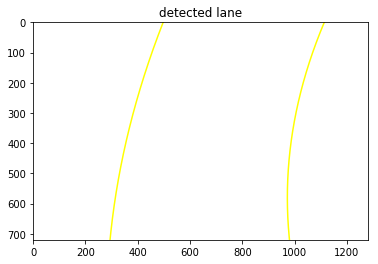

In [236]:
def get_left_right_fit(binary_warped):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    #try to find lane after perspective transformation, copy from given material
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    out_img[ploty.astype('int'),left_fitx.astype('int')] = [0, 255, 255]
    out_img[ploty.astype('int'),right_fitx.astype('int')] = [0, 255, 255]
    
    y_eval = binary_warped.shape[0]
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    mid = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2]) ) /2 - 640)*xm_per_pix
    
    return left_fit, right_fit, left_curverad,right_curverad, mid

left_fit, right_fit, _,_,_ = get_left_right_fit(binary_warped)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.title("detected lane")
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

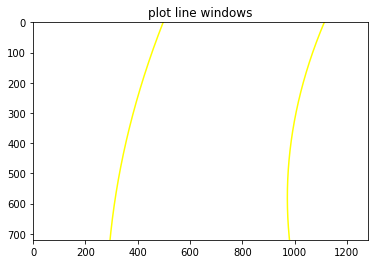

True

In [237]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 0.7, window_img, 0.3, 0)

plt.title("plot line windows")
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()
cv2.imwrite("output_images/lane_fit-test5.jpg", result)

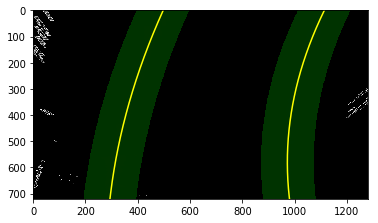

In [238]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

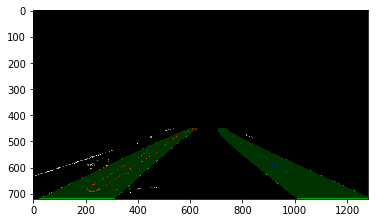

In [239]:
left_fit, right_fit, left_curverad, right_curverad, mid = get_left_right_fit(binary_warped)
result_recover = cv2.warpPerspective(result, M_prime, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(result_recover)
plt.show()

696.232693187 392.304994456


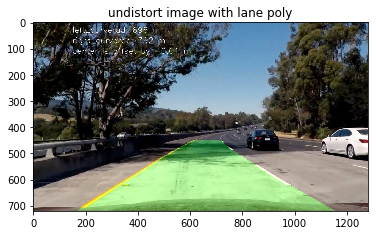

True

In [240]:
def overlay(undist, warped):
    left_fit, right_fit, left_curverad, right_curverad, mid = get_left_right_fit(warped)
    print (left_curverad, right_curverad)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_prime, (color_warp.shape[1], color_warp.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    try:
        text_l = "left_curverad: " + str(int(left_curverad)) + " m"
        text_r = "right_curverad: " + str(int(right_curverad)) + " m"
        mid = "center is offset by " + str(round( mid,2)) + " m"
    except:
        text_l = "left_curverad: can't find"
        text_r = "right_curverad: can't find"
        mid = "center can't find"
    cv2.putText(result, text_l, (150,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 1,  lineType = cv2.LINE_AA)
    cv2.putText(result, text_r, (150,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 1,  lineType = cv2.LINE_AA)
    cv2.putText(result, mid, (150,120), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 1,  lineType = cv2.LINE_AA)
    return result

plt.title("undistort image with lane poly")
result_recover = overlay(img2, binary_warped)
plt.imshow(result_recover)
plt.show()
cv2.imwrite("output_images/plottest5.jpg", cv2.cvtColor(result_recover,cv2.COLOR_BGR2RGB))


438.147238142 254.133396549


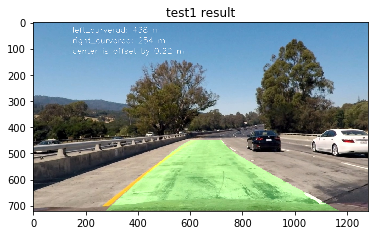

447.79702352 319.771807969


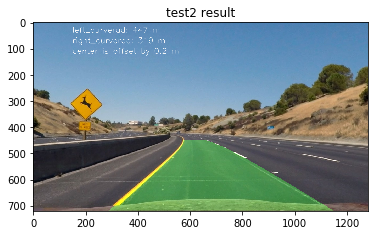

553.42785168 576.158988449


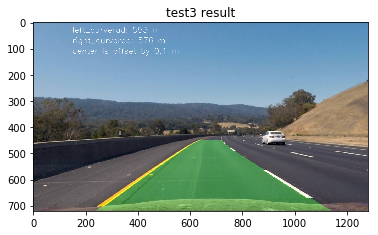

1125.78175908 466.322842774


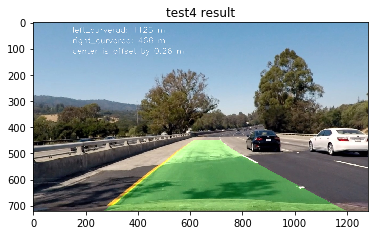

736.588486689 399.962182571


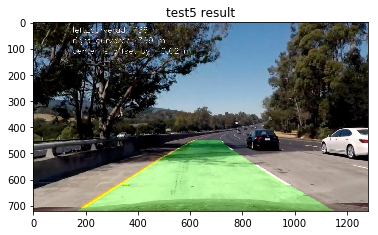

19694.6594348 644.096397493


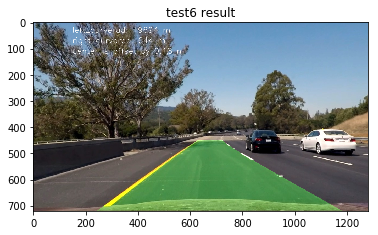

In [241]:
def render_lane_line_overlay(img,mtx=mtx,dist=dist):
    
    undist = cv2.undistort(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), mtx, dist, None, mtx)
    
    warped = get_bird_eye_binary_wrap(undist)
    #plt.imshow(binary_wrap,cmap='gray')
    #plt.show()
    left_fit, right_fit, left_curverad, right_curverad, mid = get_left_right_fit(warped)
    print (left_curverad, right_curverad)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_prime, (color_warp.shape[1], color_warp.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    try:
        text_l = "left_curverad: " + str(int(left_curverad)) + " m"
        text_r = "right_curverad: " + str(int(right_curverad)) + " m"
        mid = "center is offset by " + str(round( mid,2)) + " m"
    except:
        text_l = "left_curverad: can't find"
        text_r = "right_curverad: can't find"
        mid = "center can't find"
    cv2.putText(result, text_l, (150,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 1,  lineType = cv2.LINE_AA)
    cv2.putText(result, text_r, (150,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 1,  lineType = cv2.LINE_AA)
    cv2.putText(result, mid, (150,120), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 1,  lineType = cv2.LINE_AA)
    return result

img = cv2.imread("test_images/test1.jpg")
plt.title('test1 result')
plt.imshow(render_lane_line_overlay(img))
plt.show()

img = cv2.imread("test_images/test2.jpg")
plt.title('test2 result')
plt.imshow(render_lane_line_overlay(img))
plt.show()

img = cv2.imread("test_images/test3.jpg")
plt.title('test3 result')
plt.imshow(render_lane_line_overlay(img))
plt.show()

img = cv2.imread("test_images/test4.jpg")
plt.title('test4 result')
plt.imshow(render_lane_line_overlay(img))
plt.show()

img = cv2.imread("test_images/test5.jpg")
plt.title('test5 result')
plt.imshow(render_lane_line_overlay(img))
plt.show()

img = cv2.imread("test_images/test6.jpg")
plt.title('test6 result')
plt.imshow(render_lane_line_overlay(img))
plt.show()

In [ ]:
from collections import deque

buffer_size = 40

def get_avg_left_right_fit(binary_wrap, left_fits=deque(maxlen=buffer_size), right_fits=deque(maxlen=buffer_size)):
    left_fit, right_fit, left_curverad, right_curverad, mid = get_left_right_fit(binary_wrap)
    if abs(left_curverad - right_curverad) < 10*min(left_curverad, right_curverad):
        left_fits.append(left_fit)
        right_fits.append(right_fit)
    weights = np.arange(1,len(left_fits)+1)/len(left_fits)
    return np.average(left_fits,0,weights[-len(left_fits):]), np.average(right_fits,0,weights[-len(right_fits):]), left_curverad, right_curverad, mid

def render_avg_lane_line_overlay(img,mtx=mtx,dist=dist):
    
    undist = cv2.undistort(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), mtx, dist, None, mtx)
    
    warped = get_bird_eye_binary_wrap(undist)
    #plt.imshow(binary_wrap,cmap='gray')
    #plt.show()
    left_fit, right_fit, left_curverad, right_curverad, mid = get_avg_left_right_fit(warped)
    print (left_curverad, right_curverad)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_prime, (color_warp.shape[1], color_warp.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    try:
        text_l = "left_curverad: " + str(int(left_curverad)) + " m"
        text_r = "right_curverad: " + str(int(right_curverad)) + " m"
        mid = "center is offset by " + str(round( mid,2)) + " m"
    except:
        text_l = "left_curverad: can't find"
        text_r = "right_curverad: can't find"
        mid = "center can't find"
    cv2.putText(result, text_l, (150,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 1,  lineType = cv2.LINE_AA)
    cv2.putText(result, text_r, (150,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 1,  lineType = cv2.LINE_AA)
    cv2.putText(result, mid, (150,120), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 1,  lineType = cv2.LINE_AA)
    return result




In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy as mve
img = None

def process(img):
    return cv2.cvtColor(render_avg_lane_line_overlay(img), cv2.COLOR_BGR2RGB)

#Create video file pipeline
counter=0
output = 'test_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
test_clip = clip1.fl_image(process)
%time test_clip.write_videofile(output, audio=False)
print(counter)
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

457.248371746 879.96452655
[MoviePy] >>>> Building video test_video.mp4
[MoviePy] Writing video test_video.mp4


  0%|          | 1/1261 [00:00<06:07,  3.43it/s]

457.248371746 879.96452655


  0%|          | 2/1261 [00:00<06:07,  3.43it/s]

444.012778075 597.07605666


  0%|          | 3/1261 [00:00<06:04,  3.45it/s]

441.931693774 653.138853214


  0%|          | 4/1261 [00:01<06:02,  3.47it/s]

441.714433919 655.329163066


  0%|          | 5/1261 [00:01<06:00,  3.48it/s]

480.595385492 573.20317159


  0%|          | 6/1261 [00:01<05:59,  3.49it/s]

476.175636919 455.519665744


  1%|          | 7/1261 [00:02<05:58,  3.50it/s]

502.510537001 466.924140263


  1%|          | 8/1261 [00:02<06:04,  3.44it/s]

494.546131193 515.248791486


  1%|          | 9/1261 [00:02<06:01,  3.46it/s]

516.263864678 593.200824219


  1%|          | 10/1261 [00:02<05:59,  3.48it/s]

528.787647523 712.551136345


  1%|          | 11/1261 [00:03<06:04,  3.43it/s]

539.939176941 860.38732765


  1%|          | 12/1261 [00:03<06:01,  3.46it/s]

572.549140553 835.160797749


  1%|          | 13/1261 [00:03<05:58,  3.48it/s]

576.226334577 1101.57763854


  1%|          | 14/1261 [00:04<05:57,  3.48it/s]

583.865202633 743.802463884


  1%|          | 15/1261 [00:04<05:57,  3.49it/s]

539.762589415 619.860678211


  1%|▏         | 16/1261 [00:04<05:55,  3.50it/s]

526.723482003 543.678008517


  1%|▏         | 17/1261 [00:04<05:55,  3.50it/s]

532.344669011 455.112572155


  1%|▏         | 18/1261 [00:05<05:54,  3.50it/s]

496.183256931 450.445026039


  2%|▏         | 19/1261 [00:05<05:54,  3.51it/s]

546.502391719 431.311417155


  2%|▏         | 20/1261 [00:05<05:53,  3.51it/s]

538.056103101 406.70254592


  2%|▏         | 21/1261 [00:06<05:54,  3.50it/s]

565.9661793 368.070850236


  2%|▏         | 22/1261 [00:06<05:54,  3.50it/s]

591.510209261 380.393482782


  2%|▏         | 23/1261 [00:06<05:53,  3.50it/s]

583.303496713 414.447285106


  2%|▏         | 24/1261 [00:06<05:53,  3.50it/s]

517.693912816 533.080506573


  2%|▏         | 25/1261 [00:07<05:53,  3.50it/s]

477.45267668 673.817100536


  2%|▏         | 26/1261 [00:07<05:52,  3.51it/s]

494.676076826 686.053986783


  2%|▏         | 27/1261 [00:07<05:55,  3.47it/s]

474.963047008 791.363075424


  2%|▏         | 28/1261 [00:08<05:58,  3.44it/s]

499.350799633 808.544270333


  2%|▏         | 29/1261 [00:08<06:08,  3.34it/s]

485.997888225 537.724152077


  2%|▏         | 30/1261 [00:08<06:11,  3.32it/s]

438.782836623 578.012292382


  2%|▏         | 31/1261 [00:08<06:18,  3.25it/s]

408.339817831 490.764043638


  3%|▎         | 32/1261 [00:09<06:24,  3.20it/s]

371.361540291 381.496829897


  3%|▎         | 33/1261 [00:09<06:24,  3.19it/s]

374.387436933 340.406214624


  3%|▎         | 34/1261 [00:09<06:16,  3.26it/s]

356.886862813 390.158619275


  3%|▎         | 35/1261 [00:10<06:12,  3.29it/s]

347.146024414 444.037242947


  3%|▎         | 36/1261 [00:10<06:09,  3.32it/s]

342.126387396 448.717603958


  3%|▎         | 37/1261 [00:10<06:12,  3.28it/s]

329.701008639 396.391249368


  3%|▎         | 38/1261 [00:11<06:05,  3.35it/s]

323.416452579 390.546398685


  3%|▎         | 39/1261 [00:11<06:01,  3.38it/s]

320.859717276 393.294461788


  3%|▎         | 40/1261 [00:11<06:06,  3.33it/s]

331.186177409 419.227218291


  3%|▎         | 41/1261 [00:12<06:08,  3.31it/s]

339.15384197 401.062267744


  3%|▎         | 42/1261 [00:12<06:14,  3.26it/s]

353.988075183 367.327955071


  3%|▎         | 43/1261 [00:12<06:14,  3.25it/s]

380.867803658 368.78973026


  3%|▎         | 44/1261 [00:12<06:15,  3.24it/s]

398.535825173 383.709550975


  4%|▎         | 45/1261 [00:13<06:16,  3.23it/s]

419.486768609 357.869718216


  4%|▎         | 46/1261 [00:13<06:07,  3.30it/s]

431.299135108 346.446837197


  4%|▎         | 47/1261 [00:13<06:05,  3.33it/s]

443.056683363 393.175159411


  4%|▍         | 48/1261 [00:14<06:01,  3.36it/s]

463.467691886 474.614486319


  4%|▍         | 49/1261 [00:14<06:08,  3.29it/s]

496.458326814 516.304294878


  4%|▍         | 50/1261 [00:14<06:12,  3.25it/s]

512.56392183 506.868354528


  4%|▍         | 51/1261 [00:15<06:19,  3.19it/s]

519.405566795 512.396211793


  4%|▍         | 52/1261 [00:15<06:19,  3.19it/s]

530.998682821 496.831062098


  4%|▍         | 53/1261 [00:15<06:12,  3.24it/s]

532.466906054 526.167502575


  4%|▍         | 54/1261 [00:16<06:10,  3.26it/s]

535.052106399 457.306284974


  4%|▍         | 55/1261 [00:16<06:09,  3.27it/s]

557.733593863 443.197389201


  4%|▍         | 56/1261 [00:16<06:10,  3.25it/s]

568.02675137 439.926517335


  5%|▍         | 57/1261 [00:16<06:12,  3.23it/s]

558.977348164 434.554891166


  5%|▍         | 58/1261 [00:17<06:15,  3.20it/s]

562.186030137 459.681856433


  5%|▍         | 59/1261 [00:17<06:15,  3.20it/s]

518.772134076 569.442444677


  5%|▍         | 60/1261 [00:17<06:12,  3.22it/s]

502.374026197 590.91216391


  5%|▍         | 61/1261 [00:18<06:17,  3.18it/s]

509.966490173 517.040251939


  5%|▍         | 62/1261 [00:18<06:22,  3.13it/s]

482.311363739 451.08737151


  5%|▍         | 63/1261 [00:18<06:20,  3.15it/s]

510.645846258 435.387467551


  5%|▌         | 64/1261 [00:19<06:25,  3.11it/s]

491.819671269 416.252779618


  5%|▌         | 65/1261 [00:19<06:30,  3.07it/s]

510.626272983 438.835052936


  5%|▌         | 66/1261 [00:19<06:20,  3.14it/s]

488.913487183 430.577860088


  5%|▌         | 67/1261 [00:20<06:12,  3.21it/s]

512.465650147 445.465763159


  5%|▌         | 68/1261 [00:20<06:08,  3.24it/s]

544.043089778 461.554079882


  5%|▌         | 69/1261 [00:20<06:01,  3.29it/s]

530.858889279 459.07555795


  6%|▌         | 70/1261 [00:21<05:57,  3.33it/s]

588.767256331 535.756003849


  6%|▌         | 71/1261 [00:21<05:55,  3.35it/s]

592.705957536 518.727107553


  6%|▌         | 72/1261 [00:21<05:54,  3.35it/s]

593.038386514 464.967801138


  6%|▌         | 73/1261 [00:21<05:53,  3.36it/s]

589.020436185 440.21721212


  6%|▌         | 74/1261 [00:22<05:52,  3.37it/s]

606.75939237 409.500134276


  6%|▌         | 75/1261 [00:22<05:57,  3.32it/s]

637.019622172 453.217461104


  6%|▌         | 76/1261 [00:22<05:57,  3.31it/s]

618.655788398 450.527345839


  6%|▌         | 77/1261 [00:23<05:55,  3.33it/s]

708.933020677 553.556141713


  6%|▌         | 78/1261 [00:23<05:59,  3.29it/s]

757.686113528 544.716710393


  6%|▋         | 79/1261 [00:23<05:57,  3.31it/s]

771.195132663 543.524174177


  6%|▋         | 80/1261 [00:23<05:51,  3.36it/s]

738.44495904 529.86041286


  6%|▋         | 81/1261 [00:24<05:49,  3.38it/s]

706.127244273 442.447942274


  7%|▋         | 82/1261 [00:24<05:45,  3.41it/s]

695.423661218 431.32410953


  7%|▋         | 83/1261 [00:24<05:44,  3.42it/s]

681.271249668 400.473627647


  7%|▋         | 84/1261 [00:25<05:41,  3.44it/s]

700.793058589 364.866886051


  7%|▋         | 85/1261 [00:25<05:42,  3.44it/s]

614.335297434 455.944868365


  7%|▋         | 86/1261 [00:25<05:41,  3.44it/s]

589.631574198 519.586116554


  7%|▋         | 87/1261 [00:26<05:43,  3.42it/s]

508.917052507 620.118974524


  7%|▋         | 88/1261 [00:26<05:42,  3.42it/s]

464.589471488 483.501739576


  7%|▋         | 89/1261 [00:26<05:42,  3.42it/s]

431.174516126 541.34905032


  7%|▋         | 90/1261 [00:26<05:40,  3.44it/s]

397.003910088 435.284020464


  7%|▋         | 91/1261 [00:27<05:40,  3.43it/s]

401.725959162 449.009949572


  7%|▋         | 92/1261 [00:27<05:41,  3.42it/s]

418.878729432 431.915455306


  7%|▋         | 93/1261 [00:27<05:41,  3.42it/s]

411.890490633 428.438416603


  7%|▋         | 94/1261 [00:28<05:42,  3.41it/s]

401.712974345 440.65806962


  8%|▊         | 95/1261 [00:28<05:40,  3.43it/s]

414.721568827 462.251462281


  8%|▊         | 96/1261 [00:28<05:46,  3.36it/s]

421.608120237 467.981056344


  8%|▊         | 97/1261 [00:28<05:47,  3.35it/s]

414.431172096 500.41124993


  8%|▊         | 98/1261 [00:29<05:44,  3.38it/s]

436.434532327 502.890755848


  8%|▊         | 99/1261 [00:29<05:42,  3.40it/s]

416.402068069 438.061606047


  8%|▊         | 100/1261 [00:29<05:40,  3.41it/s]

427.471526963 436.554786907


  8%|▊         | 101/1261 [00:30<05:39,  3.41it/s]

402.190147067 444.154481127


  8%|▊         | 102/1261 [00:30<05:39,  3.41it/s]

391.977012402 412.77983944


  8%|▊         | 103/1261 [00:30<05:40,  3.40it/s]

394.606713233 452.837947449


  8%|▊         | 104/1261 [00:31<05:40,  3.40it/s]

412.411854464 402.344024583


  8%|▊         | 105/1261 [00:31<05:40,  3.40it/s]

429.394614042 455.560397429


  8%|▊         | 106/1261 [00:31<05:40,  3.40it/s]

443.971000091 431.530209185


  8%|▊         | 107/1261 [00:31<05:40,  3.39it/s]

471.228520021 402.265827933


  9%|▊         | 108/1261 [00:32<05:38,  3.41it/s]

422.594279679 326.251787646


  9%|▊         | 109/1261 [00:32<05:37,  3.42it/s]

417.809974586 340.474081348


  9%|▊         | 110/1261 [00:32<05:42,  3.36it/s]

408.109339564 378.063846383


  9%|▉         | 111/1261 [00:33<05:40,  3.38it/s]

400.661699231 425.363873035


  9%|▉         | 112/1261 [00:33<05:39,  3.38it/s]

423.736108914 441.444144749


  9%|▉         | 113/1261 [00:33<05:44,  3.33it/s]

390.030118536 377.912740211


  9%|▉         | 114/1261 [00:33<05:40,  3.37it/s]

388.33912103 386.527207321


  9%|▉         | 115/1261 [00:34<05:38,  3.38it/s]

358.910647085 396.517460683


  9%|▉         | 116/1261 [00:34<05:36,  3.40it/s]

364.947730598 371.07668098


  9%|▉         | 117/1261 [00:34<05:36,  3.40it/s]

376.545022506 377.270974288


  9%|▉         | 118/1261 [00:35<05:34,  3.42it/s]

382.2144351 354.120246631


  9%|▉         | 119/1261 [00:35<05:34,  3.41it/s]

387.095986051 354.693598993


 10%|▉         | 120/1261 [00:35<05:33,  3.42it/s]

366.300301213 374.801914964


 10%|▉         | 121/1261 [00:36<05:33,  3.42it/s]

376.034077896 390.48742198


 10%|▉         | 122/1261 [00:36<05:32,  3.43it/s]

372.305264318 412.422208456


 10%|▉         | 123/1261 [00:36<05:32,  3.42it/s]

363.387265257 377.937203635


 10%|▉         | 124/1261 [00:36<05:30,  3.44it/s]

367.496639635 371.936086055


 10%|▉         | 125/1261 [00:37<05:29,  3.45it/s]

368.146874278 357.092730047


 10%|▉         | 126/1261 [00:37<05:27,  3.47it/s]

387.269859881 417.334655808


 10%|█         | 127/1261 [00:37<05:26,  3.47it/s]

395.580320053 397.921150526


 10%|█         | 128/1261 [00:38<05:25,  3.48it/s]

404.20674241 384.465488395


 10%|█         | 129/1261 [00:38<05:25,  3.48it/s]

388.939849512 380.876699366


 10%|█         | 130/1261 [00:38<05:25,  3.47it/s]

421.64397013 371.906436593


 10%|█         | 131/1261 [00:38<05:35,  3.37it/s]

429.418868279 403.11199968


 10%|█         | 132/1261 [00:39<05:34,  3.38it/s]

423.538360204 430.117275464


 11%|█         | 133/1261 [00:39<05:31,  3.41it/s]

438.805851727 424.905610691


 11%|█         | 134/1261 [00:39<05:30,  3.41it/s]

447.749229624 535.966200504


 11%|█         | 135/1261 [00:40<05:30,  3.41it/s]

460.857280642 455.166340527


 11%|█         | 136/1261 [00:40<05:29,  3.41it/s]

470.344113787 474.745915613


 11%|█         | 137/1261 [00:40<05:30,  3.40it/s]

494.485653661 525.208562676


 11%|█         | 138/1261 [00:40<05:28,  3.41it/s]

517.895565546 531.330782009


 11%|█         | 139/1261 [00:41<05:28,  3.42it/s]

521.313397884 570.007607944


 11%|█         | 140/1261 [00:41<05:26,  3.43it/s]

551.390760915 630.157302878


 11%|█         | 141/1261 [00:41<05:28,  3.41it/s]

539.843989347 593.813605411


 11%|█▏        | 142/1261 [00:42<05:28,  3.41it/s]

556.486380833 563.436903441


 11%|█▏        | 143/1261 [00:42<05:26,  3.42it/s]

543.262808674 449.104026901


 11%|█▏        | 144/1261 [00:42<05:24,  3.44it/s]

550.734790468 454.491939167


 11%|█▏        | 145/1261 [00:43<05:30,  3.38it/s]

540.047139742 474.293843799


 12%|█▏        | 146/1261 [00:43<05:27,  3.40it/s]

503.052882727 553.037337273


 12%|█▏        | 147/1261 [00:43<05:26,  3.41it/s]

520.526755791 551.687460434


 12%|█▏        | 148/1261 [00:43<05:31,  3.36it/s]

469.834206056 491.848467261


 12%|█▏        | 149/1261 [00:44<05:28,  3.39it/s]

459.216951476 483.039366821


 12%|█▏        | 150/1261 [00:44<05:25,  3.41it/s]

466.260904398 502.382292695


 12%|█▏        | 151/1261 [00:44<05:28,  3.38it/s]

467.474121883 492.889868627


 12%|█▏        | 152/1261 [00:45<05:29,  3.37it/s]

486.924001841 536.014461173


 12%|█▏        | 153/1261 [00:45<05:28,  3.37it/s]

475.598075325 442.639420844


 12%|█▏        | 154/1261 [00:45<05:28,  3.37it/s]

504.178919825 499.405604014


 12%|█▏        | 155/1261 [00:46<05:26,  3.39it/s]

526.486446173 487.676670394


 12%|█▏        | 156/1261 [00:46<05:25,  3.39it/s]

527.709217323 440.458809608


 12%|█▏        | 157/1261 [00:46<05:25,  3.40it/s]

492.332698924 441.102912533


 13%|█▎        | 158/1261 [00:46<05:23,  3.41it/s]

468.319421098 496.828851238


 13%|█▎        | 159/1261 [00:47<05:21,  3.43it/s]

463.351368334 546.028802808


 13%|█▎        | 160/1261 [00:47<05:19,  3.45it/s]

446.757716275 390.799196032


 13%|█▎        | 161/1261 [00:47<05:18,  3.45it/s]

459.207140529 492.051453159


 13%|█▎        | 162/1261 [00:48<05:17,  3.46it/s]

459.263965358 469.213236002


 13%|█▎        | 163/1261 [00:48<05:18,  3.45it/s]

479.368546347 493.289366953


 13%|█▎        | 164/1261 [00:48<05:21,  3.41it/s]

462.821738087 453.472682911


 13%|█▎        | 165/1261 [00:48<05:25,  3.37it/s]

426.408132908 331.15766845


 13%|█▎        | 166/1261 [00:49<05:25,  3.36it/s]

437.143216148 353.307392228


 13%|█▎        | 167/1261 [00:49<05:25,  3.36it/s]

408.738178279 325.219874958


 13%|█▎        | 168/1261 [00:49<05:23,  3.38it/s]

459.236302752 338.874999743


 13%|█▎        | 169/1261 [00:50<05:22,  3.38it/s]

473.596973987 357.112004556


 13%|█▎        | 170/1261 [00:50<05:19,  3.41it/s]

489.378773555 315.197516006


 14%|█▎        | 171/1261 [00:50<05:18,  3.42it/s]

481.953369462 286.139213793


 14%|█▎        | 172/1261 [00:50<05:16,  3.44it/s]

459.458138726 295.54704039


 14%|█▎        | 173/1261 [00:51<05:18,  3.42it/s]

447.139031056 275.338423813


 14%|█▍        | 174/1261 [00:51<05:15,  3.45it/s]

403.096023492 275.344956209


 14%|█▍        | 175/1261 [00:51<05:14,  3.45it/s]

375.000520257 287.768565515


 14%|█▍        | 176/1261 [00:52<05:13,  3.46it/s]

362.698235426 256.956635035


 14%|█▍        | 177/1261 [00:52<05:14,  3.44it/s]

404.995220178 303.883038412


 14%|█▍        | 178/1261 [00:52<05:14,  3.44it/s]

392.306894177 289.428029764


 14%|█▍        | 179/1261 [00:53<05:20,  3.37it/s]

395.937325069 294.572721175


 14%|█▍        | 180/1261 [00:53<05:21,  3.36it/s]

410.6396824 306.256383785


 14%|█▍        | 181/1261 [00:53<05:20,  3.36it/s]

384.228629237 308.673543993


 14%|█▍        | 182/1261 [00:53<05:25,  3.32it/s]

386.491051063 315.340674568


 15%|█▍        | 183/1261 [00:54<05:23,  3.34it/s]

353.196726185 362.964752038


 15%|█▍        | 184/1261 [00:54<05:20,  3.36it/s]

332.850262933 359.740672123


 15%|█▍        | 185/1261 [00:54<05:17,  3.39it/s]

318.236713756 364.580168891


 15%|█▍        | 186/1261 [00:55<05:16,  3.40it/s]

286.426559647 315.10451377


 15%|█▍        | 187/1261 [00:55<05:24,  3.31it/s]

287.616779865 330.35972809


 15%|█▍        | 188/1261 [00:55<05:22,  3.33it/s]

276.329903441 296.549667915


 15%|█▍        | 189/1261 [00:56<05:24,  3.31it/s]

284.093591348 305.213529879


 15%|█▌        | 190/1261 [00:56<05:20,  3.34it/s]

282.649096872 339.174282377


 15%|█▌        | 191/1261 [00:56<05:15,  3.39it/s]

282.931680841 344.798038045


 15%|█▌        | 192/1261 [00:56<05:15,  3.39it/s]

308.278999501 361.852027423


 15%|█▌        | 193/1261 [00:57<05:14,  3.40it/s]

299.656922151 338.342528318


 15%|█▌        | 194/1261 [00:57<05:11,  3.43it/s]

309.236715871 344.507657336


 15%|█▌        | 195/1261 [00:57<05:09,  3.45it/s]

319.966881186 336.860661162


 16%|█▌        | 196/1261 [00:58<05:11,  3.42it/s]

372.393679128 387.616105314


 16%|█▌        | 197/1261 [00:58<05:12,  3.40it/s]

427.289349877 420.382235609


 16%|█▌        | 198/1261 [00:58<05:12,  3.40it/s]

484.660208462 412.635819646


 16%|█▌        | 199/1261 [00:58<05:12,  3.40it/s]

525.05753485 395.77654526


 16%|█▌        | 200/1261 [00:59<05:17,  3.34it/s]

511.26760907 498.555829012


 16%|█▌        | 201/1261 [00:59<05:14,  3.37it/s]

524.533487775 527.558341102


 16%|█▌        | 202/1261 [00:59<05:12,  3.38it/s]

493.156556442 494.52897378


 16%|█▌        | 203/1261 [01:00<05:11,  3.40it/s]

459.152963909 448.865537361


 16%|█▌        | 204/1261 [01:00<05:11,  3.39it/s]

470.47125672 484.972864517


 16%|█▋        | 205/1261 [01:00<05:08,  3.42it/s]

448.096196608 422.029987777


 16%|█▋        | 206/1261 [01:01<05:08,  3.42it/s]

436.11435698 377.171135404


 16%|█▋        | 207/1261 [01:01<05:06,  3.44it/s]

384.742249473 451.595136716


 16%|█▋        | 208/1261 [01:01<05:05,  3.44it/s]

371.124548899 510.647419798


 17%|█▋        | 209/1261 [01:01<05:04,  3.45it/s]

381.481643326 479.556432191


 17%|█▋        | 210/1261 [01:02<05:05,  3.44it/s]

392.899513464 493.258332527


 17%|█▋        | 211/1261 [01:02<05:05,  3.44it/s]

418.161545637 612.731409711


 17%|█▋        | 212/1261 [01:02<05:07,  3.41it/s]

413.233882059 561.745618418


 17%|█▋        | 213/1261 [01:03<05:06,  3.42it/s]

401.656968931 631.501575905


 17%|█▋        | 214/1261 [01:03<05:13,  3.34it/s]

394.448689197 586.007432475


 17%|█▋        | 215/1261 [01:03<05:11,  3.35it/s]

405.745126953 603.310023082


 17%|█▋        | 216/1261 [01:03<05:09,  3.37it/s]

413.69941115 534.168734695


 17%|█▋        | 217/1261 [01:04<05:12,  3.34it/s]

415.559696483 477.182453379


 17%|█▋        | 218/1261 [01:04<05:11,  3.35it/s]

437.781831331 477.349674851


 17%|█▋        | 219/1261 [01:04<05:08,  3.38it/s]

429.574094464 454.707585177


 17%|█▋        | 220/1261 [01:05<05:06,  3.40it/s]

460.470991538 455.220862047


 18%|█▊        | 221/1261 [01:05<05:04,  3.41it/s]

478.40381349 541.213811529


 18%|█▊        | 222/1261 [01:05<05:05,  3.40it/s]

494.473795601 568.979837135


 18%|█▊        | 223/1261 [01:06<05:03,  3.42it/s]

498.294906577 540.127515584


 18%|█▊        | 224/1261 [01:06<05:02,  3.43it/s]

472.36653277 514.829727634


 18%|█▊        | 225/1261 [01:06<05:01,  3.44it/s]

480.978739767 531.05817476


 18%|█▊        | 226/1261 [01:06<05:01,  3.44it/s]

458.187081291 455.510698459


 18%|█▊        | 227/1261 [01:07<05:00,  3.44it/s]

472.706455313 476.329220878


 18%|█▊        | 228/1261 [01:07<04:59,  3.44it/s]

504.982005159 480.792985342


 18%|█▊        | 229/1261 [01:07<05:00,  3.43it/s]

534.078958016 449.13043541


 18%|█▊        | 230/1261 [01:08<04:59,  3.44it/s]

566.666830692 437.733960275


 18%|█▊        | 231/1261 [01:08<04:59,  3.44it/s]

537.314222203 380.982870624


 18%|█▊        | 232/1261 [01:08<04:58,  3.45it/s]

580.391802167 361.608897621


 18%|█▊        | 233/1261 [01:08<04:58,  3.44it/s]

563.35273243 358.722014673


 19%|█▊        | 234/1261 [01:09<04:58,  3.44it/s]

544.541787782 399.468281142


 19%|█▊        | 235/1261 [01:09<05:04,  3.37it/s]

514.995605222 377.897120399


 19%|█▊        | 236/1261 [01:09<05:02,  3.39it/s]

461.046843068 337.043601367


 19%|█▉        | 237/1261 [01:10<05:02,  3.38it/s]

460.652480786 342.543647158


 19%|█▉        | 238/1261 [01:10<05:01,  3.40it/s]

438.182848368 310.111209478


 19%|█▉        | 239/1261 [01:10<04:59,  3.41it/s]

428.334707658 332.421038951


 19%|█▉        | 240/1261 [01:10<04:58,  3.42it/s]

430.606257278 330.920190611


 19%|█▉        | 241/1261 [01:11<04:57,  3.43it/s]

443.996684821 355.151546794


 19%|█▉        | 242/1261 [01:11<04:56,  3.43it/s]

466.985734175 359.167593784


 19%|█▉        | 243/1261 [01:11<04:57,  3.42it/s]

430.069683633 359.438412395


 19%|█▉        | 244/1261 [01:12<04:55,  3.44it/s]

447.243310331 398.204095873


 19%|█▉        | 245/1261 [01:12<04:54,  3.45it/s]

432.261695654 398.066755396


 20%|█▉        | 246/1261 [01:12<04:53,  3.46it/s]

412.312476483 306.333677735


 20%|█▉        | 247/1261 [01:13<04:54,  3.44it/s]

418.084460923 324.778451088


 20%|█▉        | 248/1261 [01:13<04:55,  3.43it/s]

395.458863548 319.359046346


 20%|█▉        | 249/1261 [01:13<04:58,  3.39it/s]

425.666124509 327.584631139


 20%|█▉        | 250/1261 [01:13<04:56,  3.41it/s]

422.620208748 345.44158668


 20%|█▉        | 251/1261 [01:14<04:56,  3.40it/s]

432.036962192 342.126503406


 20%|█▉        | 252/1261 [01:14<04:59,  3.37it/s]

443.335484151 362.264765722


 20%|██        | 253/1261 [01:14<04:58,  3.38it/s]

472.967954012 372.622176409


 20%|██        | 254/1261 [01:15<04:57,  3.38it/s]

499.984961274 391.682125035


 20%|██        | 255/1261 [01:15<04:56,  3.40it/s]

463.85167591 419.129052931


 20%|██        | 256/1261 [01:15<04:55,  3.41it/s]

483.70020424 391.987080024


 20%|██        | 257/1261 [01:15<04:55,  3.40it/s]

459.815069272 322.849870245


 20%|██        | 258/1261 [01:16<04:53,  3.41it/s]

455.989349272 332.605526334


 21%|██        | 259/1261 [01:16<04:54,  3.40it/s]

462.831635224 348.174306298


 21%|██        | 260/1261 [01:16<04:52,  3.42it/s]

453.101145309 347.649645875


 21%|██        | 261/1261 [01:17<04:51,  3.43it/s]

482.703650616 379.123257553


 21%|██        | 262/1261 [01:17<04:50,  3.44it/s]

487.000547246 340.126204983


 21%|██        | 263/1261 [01:17<04:52,  3.41it/s]

486.417345163 356.823486272


 21%|██        | 264/1261 [01:18<04:50,  3.43it/s]

491.365727452 366.858266494


 21%|██        | 265/1261 [01:18<04:52,  3.41it/s]

519.242613143 381.359753928


 21%|██        | 266/1261 [01:18<04:51,  3.42it/s]

549.477602915 402.145976571


 21%|██        | 267/1261 [01:18<04:52,  3.40it/s]

537.518018812 436.503200555


 21%|██▏       | 268/1261 [01:19<04:50,  3.41it/s]

544.284325748 460.247067163


 21%|██▏       | 269/1261 [01:19<04:55,  3.35it/s]

567.419318352 484.271218281


 21%|██▏       | 270/1261 [01:19<04:55,  3.35it/s]

557.359046309 601.09870637


 21%|██▏       | 271/1261 [01:20<04:55,  3.35it/s]

558.116381876 616.847467061


 22%|██▏       | 272/1261 [01:20<04:52,  3.38it/s]

549.584739935 513.031222455


 22%|██▏       | 273/1261 [01:20<04:52,  3.38it/s]

561.288931791 446.651391684


 22%|██▏       | 274/1261 [01:20<04:49,  3.40it/s]

553.2311393 432.634848722


 22%|██▏       | 275/1261 [01:21<04:50,  3.39it/s]

567.606639191 446.596155752


 22%|██▏       | 276/1261 [01:21<04:48,  3.41it/s]

605.785881187 474.32056092


 22%|██▏       | 277/1261 [01:21<04:49,  3.40it/s]

692.777722268 487.894274627


 22%|██▏       | 278/1261 [01:22<04:47,  3.43it/s]

698.816983142 500.169113769


 22%|██▏       | 279/1261 [01:22<04:49,  3.40it/s]

704.216577975 582.699754665


 22%|██▏       | 280/1261 [01:22<04:53,  3.34it/s]

723.12253632 597.074900482


 22%|██▏       | 281/1261 [01:23<04:52,  3.35it/s]

766.113236186 648.116188145


 22%|██▏       | 282/1261 [01:23<04:49,  3.39it/s]

720.950927126 619.840156797


 22%|██▏       | 283/1261 [01:23<04:48,  3.39it/s]

779.08911277 635.100910136


 23%|██▎       | 284/1261 [01:23<04:46,  3.41it/s]

756.413699119 540.331476181


 23%|██▎       | 285/1261 [01:24<04:45,  3.41it/s]

825.425383771 636.304227872


 23%|██▎       | 286/1261 [01:24<04:48,  3.38it/s]

848.91833864 636.882129434


 23%|██▎       | 287/1261 [01:24<04:46,  3.39it/s]

861.822183459 516.816978433


 23%|██▎       | 288/1261 [01:25<04:47,  3.39it/s]

923.36662124 565.695003888


 23%|██▎       | 289/1261 [01:25<04:46,  3.40it/s]

916.946534115 516.508075257


 23%|██▎       | 290/1261 [01:25<04:48,  3.37it/s]

1010.89780027 556.382565453


 23%|██▎       | 291/1261 [01:25<04:45,  3.40it/s]

917.674670057 692.148008122


 23%|██▎       | 292/1261 [01:26<04:43,  3.41it/s]

931.541245277 811.11701883


 23%|██▎       | 293/1261 [01:26<04:42,  3.43it/s]

967.66668427 736.160962733


 23%|██▎       | 294/1261 [01:26<04:41,  3.44it/s]

985.282689091 749.263790719


 23%|██▎       | 295/1261 [01:27<04:40,  3.45it/s]

1054.25147154 935.237711381


 23%|██▎       | 296/1261 [01:27<04:39,  3.45it/s]

999.465517627 781.979523933


 24%|██▎       | 297/1261 [01:27<04:39,  3.45it/s]

1007.76420718 856.522896933


 24%|██▎       | 298/1261 [01:28<04:38,  3.45it/s]

1211.60713 723.210333966


 24%|██▎       | 299/1261 [01:28<04:38,  3.46it/s]

1231.06262812 677.912972507


 24%|██▍       | 300/1261 [01:28<04:38,  3.45it/s]

1195.41813922 824.10211479


 24%|██▍       | 301/1261 [01:28<04:38,  3.45it/s]

1345.34953364 902.028543507


 24%|██▍       | 302/1261 [01:29<04:39,  3.43it/s]

1628.97146929 908.135717827


 24%|██▍       | 303/1261 [01:29<04:40,  3.42it/s]

1583.01290745 1053.04843007


 24%|██▍       | 304/1261 [01:29<04:45,  3.35it/s]

1928.33956937 1422.36627339


 24%|██▍       | 305/1261 [01:30<04:44,  3.36it/s]

2123.76019908 3192.4188489


 24%|██▍       | 306/1261 [01:30<04:43,  3.37it/s]

2174.085344 19065.667605


 24%|██▍       | 307/1261 [01:30<04:41,  3.39it/s]

2292.69853867 17314.6629023


 24%|██▍       | 308/1261 [01:30<04:40,  3.39it/s]

2541.27926138 1406.46997023


 25%|██▍       | 309/1261 [01:31<04:39,  3.41it/s]

2824.53729278 1156.98647552


 25%|██▍       | 310/1261 [01:31<04:40,  3.39it/s]

3302.79567543 984.460615451


 25%|██▍       | 311/1261 [01:31<04:39,  3.40it/s]

4129.33765216 1377.58963272


 25%|██▍       | 312/1261 [01:32<04:40,  3.38it/s]

4997.81156368 1804.75659305


 25%|██▍       | 313/1261 [01:32<04:38,  3.40it/s]

9003.74006649 1472.25935885


 25%|██▍       | 314/1261 [01:32<04:38,  3.40it/s]

24316.4871639 1776.18008598


 25%|██▍       | 315/1261 [01:33<04:37,  3.41it/s]

295902.363025 1306.14052982


 25%|██▌       | 316/1261 [01:33<04:35,  3.43it/s]

49199.6391145 1397.78883605


 25%|██▌       | 317/1261 [01:33<04:35,  3.43it/s]

31831.5851659 1378.64508404


 25%|██▌       | 318/1261 [01:33<04:43,  3.32it/s]

27066.0387407 732.774673594


 25%|██▌       | 319/1261 [01:34<04:45,  3.30it/s]

31040.9333454 854.700846079


 25%|██▌       | 320/1261 [01:34<04:41,  3.34it/s]

46407.6721815 932.727582122


 25%|██▌       | 321/1261 [01:34<04:38,  3.37it/s]

14856.4877022 990.473705374


 26%|██▌       | 322/1261 [01:35<04:36,  3.40it/s]

15521.7796638 965.889085399


 26%|██▌       | 323/1261 [01:35<04:35,  3.40it/s]

8705.43478797 1220.58617975


 26%|██▌       | 324/1261 [01:35<04:33,  3.42it/s]

11638.6823507 1071.96713783


 26%|██▌       | 325/1261 [01:35<04:33,  3.42it/s]

4727.38475273 1427.54266726


 26%|██▌       | 326/1261 [01:36<04:33,  3.42it/s]

4964.59403761 1889.27269863


 26%|██▌       | 327/1261 [01:36<04:34,  3.40it/s]

4940.97300799 2143.61336063


 26%|██▌       | 328/1261 [01:36<04:33,  3.42it/s]

6317.14155974 3096.14296979


 26%|██▌       | 329/1261 [01:37<04:34,  3.40it/s]

8530.86703693 5893.34114685


 26%|██▌       | 330/1261 [01:37<04:33,  3.40it/s]

9738.7754425 95882.0741866


 26%|██▌       | 331/1261 [01:37<04:34,  3.38it/s]

8728.40968477 4566.26502278


 26%|██▋       | 332/1261 [01:38<04:33,  3.39it/s]

8210.75350668 1881.32989746


 26%|██▋       | 333/1261 [01:38<04:32,  3.40it/s]

23589.0018688 2108.56820783


 26%|██▋       | 334/1261 [01:38<04:31,  3.42it/s]

12216.029647 2436.37871267


 27%|██▋       | 335/1261 [01:38<04:33,  3.39it/s]

22876.6584593 4617.58246868


 27%|██▋       | 336/1261 [01:39<04:34,  3.37it/s]

11030.3919892 2160.30528759


 27%|██▋       | 337/1261 [01:39<04:35,  3.36it/s]

10574.7389155 2205.10553935


 27%|██▋       | 338/1261 [01:39<04:36,  3.34it/s]

5661.44736915 3210.23975762


 27%|██▋       | 339/1261 [01:40<04:38,  3.31it/s]

9516.80009592 5295.55829443


 27%|██▋       | 340/1261 [01:40<04:35,  3.35it/s]

17243.9038213 43920.921989


 27%|██▋       | 341/1261 [01:40<04:34,  3.35it/s]

43458.7525481 4516.66522611


 27%|██▋       | 342/1261 [01:40<04:32,  3.38it/s]

14721.3409762 1074.89722219


 27%|██▋       | 343/1261 [01:41<04:33,  3.36it/s]

12870.0641631 1244.36476803


 27%|██▋       | 344/1261 [01:41<04:32,  3.37it/s]

7591.34284135 1255.76465527


 27%|██▋       | 345/1261 [01:41<04:30,  3.38it/s]

6165.01058703 1791.420613


 27%|██▋       | 346/1261 [01:42<04:31,  3.37it/s]

6158.82692665 1475.47343838


 28%|██▊       | 347/1261 [01:42<04:30,  3.37it/s]

8200.38678978 1453.65189663


 28%|██▊       | 348/1261 [01:42<04:31,  3.36it/s]

8216.24279113 1697.90873759


 28%|██▊       | 349/1261 [01:43<04:30,  3.37it/s]

5943.10429094 1888.44877343


 28%|██▊       | 350/1261 [01:43<04:30,  3.36it/s]

12738.5202058 1993.17324398


 28%|██▊       | 351/1261 [01:43<04:28,  3.39it/s]

12201.0942757 2533.893515


 28%|██▊       | 352/1261 [01:43<04:35,  3.30it/s]

10340.070321 2731.32682541


 28%|██▊       | 353/1261 [01:44<04:31,  3.34it/s]

6640.2714283 2193.63410949


 28%|██▊       | 354/1261 [01:44<04:30,  3.36it/s]

20813.3823338 3575.06253425


 28%|██▊       | 355/1261 [01:44<04:33,  3.32it/s]

35284.9016741 4545.57450565


 28%|██▊       | 356/1261 [01:45<04:30,  3.34it/s]

305513.673431 3211.8618638


 28%|██▊       | 357/1261 [01:45<04:27,  3.38it/s]

3370.94591634 2082.38740665


 28%|██▊       | 358/1261 [01:45<04:27,  3.37it/s]

3093.90223063 1299.51482532


 28%|██▊       | 359/1261 [01:46<04:26,  3.38it/s]

2161.08751899 1541.19497987


 29%|██▊       | 360/1261 [01:46<04:27,  3.37it/s]

1901.54079537 1745.0612084


 29%|██▊       | 361/1261 [01:46<04:25,  3.39it/s]

1720.57786243 1844.13829215


 29%|██▊       | 362/1261 [01:46<04:24,  3.40it/s]

1244.56965613 3288.7222988


 29%|██▉       | 363/1261 [01:47<04:24,  3.39it/s]

1153.35469288 5517.2548807


 29%|██▉       | 364/1261 [01:47<04:25,  3.38it/s]

1175.13309516 3834.24425482


 29%|██▉       | 365/1261 [01:47<04:23,  3.40it/s]

1158.60820827 9903.94338853


 29%|██▉       | 366/1261 [01:48<04:25,  3.37it/s]

1186.74540816 5112.51358845


 29%|██▉       | 367/1261 [01:48<04:23,  3.39it/s]

1181.99012064 4906.43086953


 29%|██▉       | 368/1261 [01:48<04:24,  3.38it/s]

1292.19296363 5553.50587207


 29%|██▉       | 369/1261 [01:49<04:24,  3.37it/s]

1378.40366615 2480.27897085


 29%|██▉       | 370/1261 [01:49<04:24,  3.37it/s]

1517.60137198 3856.03807864


 29%|██▉       | 371/1261 [01:49<04:23,  3.38it/s]

1830.54800376 3991.06060525


 30%|██▉       | 372/1261 [01:49<04:24,  3.37it/s]

2187.68406052 3211.37925538


 30%|██▉       | 373/1261 [01:50<04:30,  3.28it/s]

2446.91975291 3814.58529135


 30%|██▉       | 374/1261 [01:50<04:28,  3.30it/s]

3552.81141709 12494.3647791


 30%|██▉       | 375/1261 [01:50<04:27,  3.32it/s]

5043.05501034 95561.379603


 30%|██▉       | 376/1261 [01:51<04:24,  3.35it/s]

11432373.3672 55661.158267


 30%|██▉       | 377/1261 [01:51<04:23,  3.35it/s]

20447.8688863 4500.99555312


 30%|██▉       | 378/1261 [01:51<04:22,  3.37it/s]

4972.82353285 4049.89179948


 30%|███       | 379/1261 [01:52<04:21,  3.37it/s]

3500.91371848 4757.30085606


 30%|███       | 380/1261 [01:52<04:22,  3.35it/s]

3050.14581219 5191.19407749


 30%|███       | 381/1261 [01:52<04:20,  3.38it/s]

2529.50065954 7006.12617204


 30%|███       | 382/1261 [01:52<04:19,  3.39it/s]

2806.42907936 5660.62264583


 30%|███       | 383/1261 [01:53<04:18,  3.39it/s]

2467.26472112 6271.7429479


 30%|███       | 384/1261 [01:53<04:19,  3.37it/s]

2247.54927079 5400.46476655


 31%|███       | 385/1261 [01:53<04:17,  3.40it/s]

2591.29284391 6417.44262567


 31%|███       | 386/1261 [01:54<04:17,  3.39it/s]

2796.14885008 5930.60733152


 31%|███       | 387/1261 [01:54<04:21,  3.34it/s]

2895.69329197 5436.18063688


 31%|███       | 388/1261 [01:54<04:19,  3.36it/s]

3010.50280457 4709.30174752


 31%|███       | 389/1261 [01:54<04:23,  3.31it/s]

3169.4321273 3385.78933313


 31%|███       | 390/1261 [01:55<04:22,  3.32it/s]

3035.24259768 3171.74727741


 31%|███       | 391/1261 [01:55<04:20,  3.34it/s]

3628.83612026 8001.1692233


 31%|███       | 392/1261 [01:55<04:19,  3.35it/s]

3335.74559722 3694.17466954


 31%|███       | 393/1261 [01:56<04:19,  3.34it/s]

3548.02090085 1625.45628638


 31%|███       | 394/1261 [01:56<04:19,  3.34it/s]

3627.26248553 1860.80921117


 31%|███▏      | 395/1261 [01:56<04:16,  3.37it/s]

4365.0138082 1920.45312641


 31%|███▏      | 396/1261 [01:57<04:16,  3.37it/s]

6209.99027006 3504.14455517


 31%|███▏      | 397/1261 [01:57<04:15,  3.39it/s]

8279.8183547 3416.09200707


 32%|███▏      | 398/1261 [01:57<04:14,  3.39it/s]

47100.9069539 2522.90729245


 32%|███▏      | 399/1261 [01:57<04:12,  3.41it/s]

19889.2700363 2484.36137445


 32%|███▏      | 400/1261 [01:58<04:12,  3.40it/s]

25117.1775791 17183.7991881


 32%|███▏      | 401/1261 [01:58<04:13,  3.40it/s]

32767.5107915 2807.45346169


 32%|███▏      | 402/1261 [01:58<04:14,  3.37it/s]

25455.8962344 2101.71100109


 32%|███▏      | 403/1261 [01:59<04:18,  3.32it/s]

36351.2932752 10038.9668642


 32%|███▏      | 404/1261 [01:59<04:18,  3.32it/s]

39520.1222689 5079.68739919


 32%|███▏      | 405/1261 [01:59<04:17,  3.32it/s]

30100.3968849 5702.65332588


 32%|███▏      | 406/1261 [02:00<04:15,  3.35it/s]

55666.9531128 3244.15614933


 32%|███▏      | 407/1261 [02:00<04:24,  3.23it/s]

54627.853625 2483.11688645


 32%|███▏      | 408/1261 [02:00<04:31,  3.14it/s]

17492.7493799 4560.56366131


 32%|███▏      | 409/1261 [02:01<04:36,  3.08it/s]

27377.8606186 6898.03977232


 33%|███▎      | 410/1261 [02:01<04:35,  3.09it/s]

50809.283844 4247.57860089


 33%|███▎      | 411/1261 [02:01<04:36,  3.08it/s]

50744.3894395 9486.00394674


 33%|███▎      | 412/1261 [02:01<04:28,  3.16it/s]

8319.46875422 43643.4461579


 33%|███▎      | 413/1261 [02:02<04:21,  3.24it/s]

5611.35104432 2894.95500634


 33%|███▎      | 414/1261 [02:02<04:19,  3.26it/s]

4626.27230869 3201.00562237


 33%|███▎      | 415/1261 [02:02<04:15,  3.31it/s]

3917.75528839 12197.2154851


 33%|███▎      | 416/1261 [02:03<04:12,  3.35it/s]

3518.01908951 17398.8293738


 33%|███▎      | 417/1261 [02:03<04:10,  3.37it/s]

3488.78899 3114.72330663


 33%|███▎      | 418/1261 [02:03<04:11,  3.36it/s]

2713.25296143 1882.82842428


 33%|███▎      | 419/1261 [02:04<04:14,  3.30it/s]

2579.81762678 3409.6209288


 33%|███▎      | 420/1261 [02:04<04:15,  3.29it/s]

2601.88722734 5627.66814093


 33%|███▎      | 421/1261 [02:04<04:16,  3.28it/s]

3211.35892824 4043.26800418


 33%|███▎      | 422/1261 [02:04<04:13,  3.31it/s]

3936.93319329 6328.36342204


 34%|███▎      | 423/1261 [02:05<04:14,  3.29it/s]

3370.88089857 3893.8007072


 34%|███▎      | 424/1261 [02:05<04:10,  3.34it/s]

5320.46469617 3065.94370629


 34%|███▎      | 425/1261 [02:05<04:09,  3.34it/s]

5178.74198889 2965.47598141


 34%|███▍      | 426/1261 [02:06<04:07,  3.38it/s]

4604.42727013 1811.99846485


 34%|███▍      | 427/1261 [02:06<04:05,  3.40it/s]

9096.33966267 3258.51442741


 34%|███▍      | 428/1261 [02:06<04:04,  3.40it/s]

27646.0772932 195091.009545


 34%|███▍      | 429/1261 [02:07<04:03,  3.42it/s]

73137.2874902 5570.22875743


 34%|███▍      | 430/1261 [02:07<04:02,  3.43it/s]

12138.2456419 17568.5883124


 34%|███▍      | 431/1261 [02:07<04:01,  3.43it/s]

9330.06489987 53228.0563384


 34%|███▍      | 432/1261 [02:07<04:00,  3.44it/s]

5442.15366464 19563.777919


 34%|███▍      | 433/1261 [02:08<04:00,  3.44it/s]

5195.98176996 13429.9274133


 34%|███▍      | 434/1261 [02:08<03:59,  3.45it/s]

2615.75880035 4443.85241056


 34%|███▍      | 435/1261 [02:08<04:00,  3.43it/s]

2517.43630497 3433.88406746


 35%|███▍      | 436/1261 [02:09<03:59,  3.44it/s]

2305.45433005 1690.24544948


 35%|███▍      | 437/1261 [02:09<04:01,  3.41it/s]

2213.04139031 2743.38223504


 35%|███▍      | 438/1261 [02:09<04:01,  3.41it/s]

2169.68491858 2232.54992849


 35%|███▍      | 439/1261 [02:09<04:02,  3.39it/s]

1992.38008811 10830.7251342


 35%|███▍      | 440/1261 [02:10<04:00,  3.41it/s]

2073.54019479 2720.74557332


 35%|███▍      | 441/1261 [02:10<04:05,  3.34it/s]

2098.3368951 6568.91080866


 35%|███▌      | 442/1261 [02:10<04:03,  3.37it/s]

2282.23270726 2224.62133193


 35%|███▌      | 443/1261 [02:11<04:02,  3.37it/s]

2037.90446126 3596.00990071


 35%|███▌      | 444/1261 [02:11<04:00,  3.40it/s]

2238.82593634 2442.40489854


 35%|███▌      | 445/1261 [02:11<03:59,  3.41it/s]

2218.9874205 2675.14850634


 35%|███▌      | 446/1261 [02:12<03:57,  3.42it/s]

2129.81147298 1823.67168089


 35%|███▌      | 447/1261 [02:12<03:57,  3.42it/s]

2448.47801727 2076.5327874


 36%|███▌      | 448/1261 [02:12<03:56,  3.44it/s]

2784.08207238 2008.77784235


 36%|███▌      | 449/1261 [02:12<03:56,  3.43it/s]

3699.2665215 12775.569538


 36%|███▌      | 450/1261 [02:13<03:55,  3.44it/s]

3965.36038341 10869.7921844


 36%|███▌      | 451/1261 [02:13<03:55,  3.44it/s]

8806.00975768 14240.6978278


 36%|███▌      | 452/1261 [02:13<03:55,  3.44it/s]

25600.9883256 85128.8028255


 36%|███▌      | 453/1261 [02:14<03:56,  3.42it/s]

23009.5235028 14275.6821399


 36%|███▌      | 454/1261 [02:14<03:59,  3.37it/s]

5960.81754304 11008.1214635


 36%|███▌      | 455/1261 [02:14<04:02,  3.32it/s]

3508.28524478 84085.658732


 36%|███▌      | 456/1261 [02:14<03:59,  3.37it/s]

2874.58795086 12622.7522556


 36%|███▌      | 457/1261 [02:15<03:58,  3.37it/s]

3070.29349747 4827.67924288


 36%|███▋      | 458/1261 [02:15<04:04,  3.29it/s]

4054.19774832 12552.9815406


 36%|███▋      | 459/1261 [02:15<04:02,  3.30it/s]

3158.6194344 11124.501288


 36%|███▋      | 460/1261 [02:16<04:00,  3.33it/s]

2643.50249272 4786.80096718


 37%|███▋      | 461/1261 [02:16<04:03,  3.29it/s]

3121.91301273 1681.55421524


 37%|███▋      | 462/1261 [02:16<04:09,  3.21it/s]

2845.49564295 3250.11757569


 37%|███▋      | 463/1261 [02:17<04:04,  3.27it/s]

2682.30951411 1883.82959744


 37%|███▋      | 464/1261 [02:17<03:58,  3.34it/s]

2606.13822575 1448.52191805


 37%|███▋      | 465/1261 [02:17<03:58,  3.34it/s]

2495.94766297 1706.30407736


 37%|███▋      | 466/1261 [02:17<03:56,  3.36it/s]

2546.21723045 2142.56855421


 37%|███▋      | 467/1261 [02:18<03:55,  3.38it/s]

3086.17359963 2460.65918265


 37%|███▋      | 468/1261 [02:18<03:53,  3.40it/s]

3506.06312984 3563.8408021


 37%|███▋      | 469/1261 [02:18<03:53,  3.39it/s]

4970.59606301 8067.50159689


 37%|███▋      | 470/1261 [02:19<03:52,  3.41it/s]

6534.34370555 3003.81108966


 37%|███▋      | 471/1261 [02:19<03:52,  3.39it/s]

10287.7003801 11185.1843084


 37%|███▋      | 472/1261 [02:19<03:51,  3.41it/s]

17632.1134078 19753.532962


 38%|███▊      | 473/1261 [02:20<03:52,  3.39it/s]

53296.0222068 3779.89719034


 38%|███▊      | 474/1261 [02:20<03:51,  3.40it/s]

117591.763979 79108.7845316


 38%|███▊      | 475/1261 [02:20<03:56,  3.33it/s]

17321.3176502 7476.85983073


 38%|███▊      | 476/1261 [02:20<03:53,  3.37it/s]

11613.7964384 5199.18932299


 38%|███▊      | 477/1261 [02:21<03:53,  3.36it/s]

9069.90970124 6627.91987824


 38%|███▊      | 478/1261 [02:21<03:50,  3.39it/s]

10739.4456479 4358.89511445


 38%|███▊      | 479/1261 [02:21<03:50,  3.40it/s]

5859.20823043 4430.94666536


 38%|███▊      | 480/1261 [02:22<03:48,  3.42it/s]

5296.42395871 10821.4389861


 38%|███▊      | 481/1261 [02:22<03:49,  3.40it/s]

6090.75345134 15058.525037


 38%|███▊      | 482/1261 [02:22<03:47,  3.42it/s]

4566.40227083 42775.5602333


 38%|███▊      | 483/1261 [02:22<03:47,  3.42it/s]

3997.38768104 53717.1263921


 38%|███▊      | 484/1261 [02:23<03:45,  3.44it/s]

5292.09191573 4087.66636663


 38%|███▊      | 485/1261 [02:23<03:46,  3.43it/s]

7419.29271005 1336.38675105


 39%|███▊      | 486/1261 [02:23<03:46,  3.42it/s]

8368.03245749 1615.62561889


 39%|███▊      | 487/1261 [02:24<03:46,  3.42it/s]

7099.64307674 2194.73627637


 39%|███▊      | 488/1261 [02:24<03:45,  3.43it/s]

20138.8389627 21128.9304013


 39%|███▉      | 489/1261 [02:24<03:50,  3.35it/s]

45432.495579 27600.1241551


 39%|███▉      | 490/1261 [02:25<03:48,  3.37it/s]

25485.6302527 9931.28920226


 39%|███▉      | 491/1261 [02:25<03:50,  3.34it/s]

110159.940128 10778.2706096


 39%|███▉      | 492/1261 [02:25<03:49,  3.35it/s]

242777.133193 11114.4214582


 39%|███▉      | 493/1261 [02:25<03:48,  3.36it/s]

45006.1167089 5163.56900182


 39%|███▉      | 494/1261 [02:26<03:46,  3.39it/s]

15850.3512438 6660.67209868


 39%|███▉      | 495/1261 [02:26<03:45,  3.39it/s]

67874.5156633 4513.68823107


 39%|███▉      | 496/1261 [02:26<03:43,  3.42it/s]

48787.4479172 2051.57168947


 39%|███▉      | 497/1261 [02:27<03:43,  3.42it/s]

296618.695273 2025.78259719


 39%|███▉      | 498/1261 [02:27<03:42,  3.42it/s]

25909.7517401 5142.70150872


 40%|███▉      | 499/1261 [02:27<03:43,  3.41it/s]

13228.476406 9196.42606797


 40%|███▉      | 500/1261 [02:27<03:42,  3.42it/s]

6727.3494728 5808.28802392


 40%|███▉      | 501/1261 [02:28<03:42,  3.42it/s]

13448.8992797 10880.2388529


 40%|███▉      | 502/1261 [02:28<03:41,  3.42it/s]

8651.21453686 7334.3820817


 40%|███▉      | 503/1261 [02:28<03:42,  3.41it/s]

9546.81113749 3982.38214299


 40%|███▉      | 504/1261 [02:29<03:41,  3.42it/s]

9192.8329887 4109.6229642


 40%|████      | 505/1261 [02:29<03:41,  3.41it/s]

16246.3270968 6592.30754662


 40%|████      | 506/1261 [02:29<03:42,  3.39it/s]

6863.67063598 9424.07292919


 40%|████      | 507/1261 [02:30<03:41,  3.40it/s]

4674.32175985 10317.9638754


 40%|████      | 508/1261 [02:30<03:41,  3.39it/s]

7978.23919391 16968.3709485


 40%|████      | 509/1261 [02:30<03:42,  3.38it/s]

10909.9350864 2488.08919921


 40%|████      | 510/1261 [02:30<03:46,  3.32it/s]

17281.3901729 1305.2355256


 41%|████      | 511/1261 [02:31<03:44,  3.33it/s]

7314.19357537 1193.280959


 41%|████      | 512/1261 [02:31<03:43,  3.35it/s]

38304.8762994 1639.57012276


 41%|████      | 513/1261 [02:31<03:43,  3.35it/s]

19690.6459356 6101.47093483


 41%|████      | 514/1261 [02:32<03:41,  3.37it/s]

55739.3314612 13729.761787


 41%|████      | 515/1261 [02:32<03:41,  3.37it/s]

29407.3558771 5826.13305977


 41%|████      | 516/1261 [02:32<03:39,  3.39it/s]

38234.9235943 10947.825773


 41%|████      | 517/1261 [02:33<03:38,  3.40it/s]

7305.40631568 15561.3987391


 41%|████      | 518/1261 [02:33<03:37,  3.41it/s]

5292.76137399 8578.13880425


 41%|████      | 519/1261 [02:33<03:37,  3.41it/s]

4965.45423018 53128.2161176


 41%|████      | 520/1261 [02:33<03:37,  3.41it/s]

8891.73779931 6048.22576849


 41%|████▏     | 521/1261 [02:34<03:37,  3.40it/s]

5717.31224698 8755.3165269


 41%|████▏     | 522/1261 [02:34<03:36,  3.41it/s]

41481.1686701 1713.34658768


 41%|████▏     | 523/1261 [02:34<03:39,  3.35it/s]

2540.13821961 636.18507324


 42%|████▏     | 524/1261 [02:35<03:40,  3.35it/s]

3124.01604238 423.946265934


 42%|████▏     | 525/1261 [02:35<03:38,  3.36it/s]

2060.84681043 437.194280305


 42%|████▏     | 526/1261 [02:35<03:41,  3.32it/s]

1888.55113101 476.234765392


 42%|████▏     | 527/1261 [02:35<03:39,  3.35it/s]

1981.28070948 886.690868422


 42%|████▏     | 528/1261 [02:36<03:37,  3.37it/s]

1963.6802538 493.058246455


 42%|████▏     | 529/1261 [02:36<03:36,  3.38it/s]

1939.37756214 928.491288631


 42%|████▏     | 530/1261 [02:36<03:34,  3.41it/s]

2999.23749019 7916.01665568


 42%|████▏     | 531/1261 [02:37<03:32,  3.43it/s]

1954.58969475 3506.39141307


 42%|████▏     | 532/1261 [02:37<03:28,  3.49it/s]

1889.88734182 2517.5308562


 42%|████▏     | 533/1261 [02:37<03:27,  3.51it/s]

1613.66372505 626.425499103


 42%|████▏     | 534/1261 [02:37<03:25,  3.53it/s]

1880.94571214 707.406487148


 42%|████▏     | 535/1261 [02:38<03:25,  3.52it/s]

1055.90260974 750.757384365


 43%|████▎     | 536/1261 [02:38<03:24,  3.54it/s]

859.380260232 845.798720389


 43%|████▎     | 537/1261 [02:38<03:23,  3.55it/s]

949.860590641 1070.98215862


 43%|████▎     | 538/1261 [02:39<03:22,  3.56it/s]

568.325820597 1308.72208553


 43%|████▎     | 539/1261 [02:39<03:23,  3.55it/s]

1249.1055384 665.730908479


 43%|████▎     | 540/1261 [02:39<03:21,  3.57it/s]

5598.95135962 2400.87187467


 43%|████▎     | 541/1261 [02:39<03:21,  3.57it/s]

4774.85642009 2591.40587086


 43%|████▎     | 542/1261 [02:40<03:22,  3.56it/s]

5950.70336899 1182.36169257


 43%|████▎     | 543/1261 [02:40<03:22,  3.54it/s]

48524.4886457 2766.11752795


 43%|████▎     | 544/1261 [02:40<03:22,  3.54it/s]

32841.6190308 2396.43530935


 43%|████▎     | 545/1261 [02:41<03:27,  3.46it/s]

4136.65112453 1394.34984703


 43%|████▎     | 546/1261 [02:41<03:25,  3.47it/s]

14476.837848 871.764841423


 43%|████▎     | 547/1261 [02:41<03:24,  3.49it/s]

5482.80222242 864.390534181


 43%|████▎     | 548/1261 [02:41<03:21,  3.53it/s]

3330.02062788 1202.70599576


 44%|████▎     | 549/1261 [02:42<03:20,  3.56it/s]

13037.1422804 974.125707776


 44%|████▎     | 550/1261 [02:42<03:19,  3.57it/s]

2853.87245647 1062.72018412


 44%|████▎     | 551/1261 [02:42<03:19,  3.56it/s]

1240.03603009 1003.09582074


 44%|████▍     | 552/1261 [02:43<03:18,  3.58it/s]

1540.11224742 1013.97493264


 44%|████▍     | 553/1261 [02:43<03:18,  3.58it/s]

1957.71970838 1224.0445222


 44%|████▍     | 554/1261 [02:43<03:16,  3.60it/s]

2721.83608686 2071.29779553


 44%|████▍     | 555/1261 [02:43<03:16,  3.60it/s]

1771.25556429 901.541923328


 44%|████▍     | 556/1261 [02:44<03:15,  3.60it/s]

14350.8264361 878.172493385


 44%|████▍     | 557/1261 [02:44<03:16,  3.58it/s]

8892.38412817 1790.76844847


 44%|████▍     | 558/1261 [02:44<03:15,  3.59it/s]

5646.37370913 5031.95341697


 44%|████▍     | 559/1261 [02:45<03:19,  3.52it/s]

3336.29196884 2561.85902671


 44%|████▍     | 560/1261 [02:45<03:19,  3.51it/s]

1709.80376059 843.108513006


 44%|████▍     | 561/1261 [02:45<03:19,  3.52it/s]

2468.56835282 786.862154581


 45%|████▍     | 562/1261 [02:45<03:17,  3.54it/s]

18081.7910272 1191.16960574


 45%|████▍     | 563/1261 [02:46<03:17,  3.54it/s]

10297.9722795 10826.3423777


 45%|████▍     | 564/1261 [02:46<03:15,  3.57it/s]

8491.3303689 3148.52920752


 45%|████▍     | 565/1261 [02:46<03:14,  3.58it/s]

1829.40504139 659.114742089


 45%|████▍     | 566/1261 [02:46<03:13,  3.59it/s]

695.755437058 1318.85463949


 45%|████▍     | 567/1261 [02:47<03:13,  3.58it/s]

1922.68735468 1320.17030651


 45%|████▌     | 568/1261 [02:47<03:12,  3.60it/s]

4384.90488155 1723.86589362


 45%|████▌     | 569/1261 [02:47<03:12,  3.59it/s]

12573.0730688 1631.20142428


 45%|████▌     | 570/1261 [02:48<03:11,  3.61it/s]

54561.9664734 1519.05141367


 45%|████▌     | 571/1261 [02:48<03:11,  3.61it/s]

1666.63072999 2077.83323436


 45%|████▌     | 572/1261 [02:48<03:10,  3.62it/s]

981.167287399 2429.4814635


 45%|████▌     | 573/1261 [02:48<03:11,  3.60it/s]

815.015861957 1960.6247359


 46%|████▌     | 574/1261 [02:49<03:12,  3.57it/s]

1876.4978768 2333.73124913


 46%|████▌     | 575/1261 [02:49<03:12,  3.57it/s]

30075.5164905 2176.35889207


 46%|████▌     | 576/1261 [02:49<03:10,  3.59it/s]

46692.9482945 1856.76715597


 46%|████▌     | 577/1261 [02:50<03:10,  3.58it/s]

1624.63067244 6730.60317045


 46%|████▌     | 578/1261 [02:50<03:09,  3.60it/s]

36803.8218304 1247.74150349


 46%|████▌     | 579/1261 [02:50<03:08,  3.61it/s]

1516.64736838 789.157908061


 46%|████▌     | 580/1261 [02:50<03:08,  3.62it/s]

11998.3717882 1224.80854624


 46%|████▌     | 581/1261 [02:51<03:11,  3.55it/s]

8378.72503226 893.176356184


 46%|████▌     | 582/1261 [02:51<03:09,  3.58it/s]

543.535752582 1250.94588066


 46%|████▌     | 583/1261 [02:51<03:10,  3.57it/s]

999.292184901 1181.3960223


 46%|████▋     | 584/1261 [02:52<03:09,  3.57it/s]

1544.89698354 1283.72484231


 46%|████▋     | 585/1261 [02:52<03:09,  3.57it/s]

1204.59312298 1358.30830746


 46%|████▋     | 586/1261 [02:52<03:11,  3.52it/s]

704.276791033 1751.12738952


 47%|████▋     | 587/1261 [02:52<03:12,  3.50it/s]

777.125863389 2016.70692459


 47%|████▋     | 588/1261 [02:53<03:12,  3.50it/s]

1010.74986243 1464.54753333


 47%|████▋     | 589/1261 [02:53<03:11,  3.50it/s]

1044.84391972 1403.54134176


 47%|████▋     | 590/1261 [02:53<03:11,  3.50it/s]

1127.04228463 4479.00914617


 47%|████▋     | 591/1261 [02:54<03:10,  3.51it/s]

942.277097415 6143.69778909


 47%|████▋     | 592/1261 [02:54<03:11,  3.50it/s]

1432.62289322 2137.5220245


 47%|████▋     | 593/1261 [02:54<03:10,  3.51it/s]

1985.30653311 1793.3323555


 47%|████▋     | 594/1261 [02:54<03:10,  3.50it/s]

6636.23280161 3207.68497084


 47%|████▋     | 595/1261 [02:55<03:12,  3.46it/s]

4176.78657455 2055.72264267


 47%|████▋     | 596/1261 [02:55<03:17,  3.37it/s]

26093.1439432 2617.84564414


 47%|████▋     | 597/1261 [02:55<03:17,  3.35it/s]

2260.58411996 2102.20258496


 47%|████▋     | 598/1261 [02:56<03:22,  3.28it/s]

1540.28306764 1515.36674552


 48%|████▊     | 599/1261 [02:56<03:21,  3.29it/s]

1334.76160814 1055.80890661


 48%|████▊     | 600/1261 [02:56<03:22,  3.26it/s]

1930.74596143 812.314503716


 48%|████▊     | 601/1261 [02:57<03:19,  3.31it/s]

1277.65767417 684.58652939


 48%|████▊     | 602/1261 [02:57<03:16,  3.35it/s]

1421.06804449 633.977739645


 48%|████▊     | 603/1261 [02:57<03:14,  3.39it/s]

2689.43590107 499.373774945


 48%|████▊     | 604/1261 [02:57<03:11,  3.43it/s]

3404.74184042 489.308877564


 48%|████▊     | 605/1261 [02:58<03:09,  3.46it/s]

2713.47768373 410.386086125


 48%|████▊     | 606/1261 [02:58<03:08,  3.47it/s]

748.613736804 462.850802021


 48%|████▊     | 607/1261 [02:58<03:09,  3.44it/s]

317.67160314 412.584582755


 48%|████▊     | 608/1261 [02:59<03:08,  3.46it/s]

604.5821293 423.632218934


 48%|████▊     | 609/1261 [02:59<03:07,  3.47it/s]

660.023258322 455.423392743


 48%|████▊     | 610/1261 [02:59<03:07,  3.46it/s]

489.614871804 449.513651925


 48%|████▊     | 611/1261 [02:59<03:06,  3.48it/s]

667.424853744 489.085614228


 49%|████▊     | 612/1261 [03:00<03:05,  3.49it/s]

371.846895694 514.047486921


 49%|████▊     | 613/1261 [03:00<03:05,  3.49it/s]

376.272263675 517.158077141


 49%|████▊     | 614/1261 [03:00<03:09,  3.42it/s]

406.334320344 514.105996189


 49%|████▉     | 615/1261 [03:01<03:11,  3.38it/s]

406.415382936 541.694767067


 49%|████▉     | 616/1261 [03:01<03:14,  3.31it/s]

422.415426982 506.049234888


 49%|████▉     | 617/1261 [03:01<03:16,  3.28it/s]

390.858287809 669.131713691


 49%|████▉     | 618/1261 [03:02<03:24,  3.15it/s]

357.57800631 606.22740228


 49%|████▉     | 619/1261 [03:02<03:30,  3.05it/s]

288.306413492 499.290080848


 49%|████▉     | 620/1261 [03:02<03:31,  3.02it/s]

309.101825934 525.506473348


 49%|████▉     | 621/1261 [03:03<03:34,  2.99it/s]

331.956231292 519.461399306


 49%|████▉     | 622/1261 [03:03<03:28,  3.06it/s]

374.831244891 604.265871987


 49%|████▉     | 623/1261 [03:03<03:25,  3.11it/s]

375.373683572 665.543201456


 49%|████▉     | 624/1261 [03:04<03:25,  3.11it/s]

366.336044233 623.105327418


 50%|████▉     | 625/1261 [03:04<03:25,  3.09it/s]

338.887478318 445.068650569


 50%|████▉     | 626/1261 [03:04<03:26,  3.08it/s]

336.516007651 450.030899184


 50%|████▉     | 627/1261 [03:04<03:25,  3.09it/s]

333.911817513 449.56366723


 50%|████▉     | 628/1261 [03:05<03:23,  3.11it/s]

389.956511052 382.328965084


 50%|████▉     | 629/1261 [03:05<03:23,  3.11it/s]

423.093662199 356.235106098


 50%|████▉     | 630/1261 [03:05<03:24,  3.09it/s]

537.029858171 439.854324972


 50%|█████     | 631/1261 [03:06<03:26,  3.05it/s]

576.519803448 623.33721764


 50%|█████     | 632/1261 [03:06<03:28,  3.02it/s]

618.810214115 698.395851531


 50%|█████     | 633/1261 [03:06<03:26,  3.05it/s]

670.564381343 694.561151306


 50%|█████     | 634/1261 [03:07<03:27,  3.02it/s]

682.035523371 489.954826534


 50%|█████     | 635/1261 [03:07<03:26,  3.03it/s]

569.511989857 463.540964865


 50%|█████     | 636/1261 [03:07<03:27,  3.01it/s]

666.906325108 401.649843838


 51%|█████     | 637/1261 [03:08<03:24,  3.05it/s]

475.963981249 326.97910714


 51%|█████     | 638/1261 [03:08<03:25,  3.03it/s]

473.288455077 345.422652908


 51%|█████     | 639/1261 [03:08<03:22,  3.07it/s]

562.837507115 382.670726783


 51%|█████     | 640/1261 [03:09<03:18,  3.14it/s]

759.085215339 456.658428661


 51%|█████     | 641/1261 [03:09<03:18,  3.13it/s]

862.361658348 583.704581229


 51%|█████     | 642/1261 [03:09<03:13,  3.20it/s]

910.043865566 602.887077441


 51%|█████     | 643/1261 [03:10<03:13,  3.19it/s]

837.033825956 512.069414662


 51%|█████     | 644/1261 [03:10<03:10,  3.23it/s]

732.2707558 472.710588623


 51%|█████     | 645/1261 [03:10<03:08,  3.27it/s]

651.144235508 456.450098002


 51%|█████     | 646/1261 [03:11<03:05,  3.31it/s]

555.496913218 478.744814669


 51%|█████▏    | 647/1261 [03:11<03:05,  3.30it/s]

565.324903463 492.02998484


 51%|█████▏    | 648/1261 [03:11<03:06,  3.28it/s]

558.915536982 520.818558513


 51%|█████▏    | 649/1261 [03:11<03:04,  3.31it/s]

543.234785729 541.882648147


 52%|█████▏    | 650/1261 [03:12<03:03,  3.34it/s]

566.500141297 557.91339107


 52%|█████▏    | 651/1261 [03:12<03:00,  3.37it/s]

539.788699156 565.483188021


 52%|█████▏    | 652/1261 [03:12<02:59,  3.38it/s]

530.948700814 564.749318796


 52%|█████▏    | 653/1261 [03:13<02:59,  3.39it/s]

471.419869852 549.708883684


 52%|█████▏    | 654/1261 [03:13<02:57,  3.41it/s]

487.297423634 508.270607484


 52%|█████▏    | 655/1261 [03:13<02:57,  3.42it/s]

428.182227759 534.197508396


 52%|█████▏    | 656/1261 [03:14<02:58,  3.39it/s]

430.509299506 578.510558959


 52%|█████▏    | 657/1261 [03:14<02:57,  3.41it/s]

418.558096728 569.637340877


 52%|█████▏    | 658/1261 [03:14<02:57,  3.39it/s]

435.96829467 580.264466084


 52%|█████▏    | 659/1261 [03:14<02:57,  3.40it/s]

445.177420287 604.424032216


 52%|█████▏    | 660/1261 [03:15<02:56,  3.40it/s]

456.129364612 642.8232919


 52%|█████▏    | 661/1261 [03:15<03:00,  3.33it/s]

473.00859626 617.843915457


 52%|█████▏    | 662/1261 [03:15<02:59,  3.34it/s]

502.387733182 685.83043761


 53%|█████▎    | 663/1261 [03:16<02:57,  3.37it/s]

518.54599315 702.686913775


 53%|█████▎    | 664/1261 [03:16<02:57,  3.36it/s]

522.514467897 705.471887642


 53%|█████▎    | 665/1261 [03:16<02:56,  3.37it/s]

571.658136309 662.96575697


 53%|█████▎    | 666/1261 [03:16<02:57,  3.36it/s]

534.798481879 577.310628301


 53%|█████▎    | 667/1261 [03:17<02:56,  3.37it/s]

541.15813533 514.000902002


 53%|█████▎    | 668/1261 [03:17<02:55,  3.37it/s]

602.363220144 512.622912603


 53%|█████▎    | 669/1261 [03:17<02:55,  3.38it/s]

650.731952231 559.82415005


 53%|█████▎    | 670/1261 [03:18<02:54,  3.39it/s]

671.399351956 554.20391236


 53%|█████▎    | 671/1261 [03:18<02:53,  3.40it/s]

700.546289319 575.700081248


 53%|█████▎    | 672/1261 [03:18<02:52,  3.41it/s]

679.258624839 558.304493654


 53%|█████▎    | 673/1261 [03:19<02:52,  3.41it/s]

675.241015186 584.703727143


 53%|█████▎    | 674/1261 [03:19<02:52,  3.40it/s]

726.165623255 609.58968902


 54%|█████▎    | 675/1261 [03:19<02:53,  3.37it/s]

751.629223185 611.943495233


 54%|█████▎    | 676/1261 [03:19<02:53,  3.37it/s]

694.752246642 589.501509179


 54%|█████▎    | 677/1261 [03:20<02:52,  3.39it/s]

728.442702973 567.416198499


 54%|█████▍    | 678/1261 [03:20<02:51,  3.40it/s]

735.09585481 606.529969018


 54%|█████▍    | 679/1261 [03:20<02:51,  3.40it/s]

637.223383586 515.721336596


 54%|█████▍    | 680/1261 [03:21<02:51,  3.40it/s]

573.260801517 513.615930545


 54%|█████▍    | 681/1261 [03:21<02:50,  3.41it/s]

529.743767352 519.415921618


 54%|█████▍    | 682/1261 [03:21<02:54,  3.31it/s]

485.368120205 530.836834872


 54%|█████▍    | 683/1261 [03:22<02:53,  3.33it/s]

560.136519628 541.359262548


 54%|█████▍    | 684/1261 [03:22<02:52,  3.34it/s]

565.469131525 571.141400482


 54%|█████▍    | 685/1261 [03:22<02:52,  3.34it/s]

533.992543779 585.914495371


 54%|█████▍    | 686/1261 [03:22<02:51,  3.36it/s]

500.107747313 558.991396039


 54%|█████▍    | 687/1261 [03:23<02:50,  3.37it/s]

522.226214856 551.075904401


 55%|█████▍    | 688/1261 [03:23<02:49,  3.39it/s]

493.238898907 596.584365731


 55%|█████▍    | 689/1261 [03:23<02:48,  3.40it/s]

546.01242834 621.75234771


 55%|█████▍    | 690/1261 [03:24<02:48,  3.39it/s]

525.408243222 623.912874637


 55%|█████▍    | 691/1261 [03:24<02:48,  3.38it/s]

451.817941527 594.275532239


 55%|█████▍    | 692/1261 [03:24<02:47,  3.39it/s]

440.498512296 531.906988094


 55%|█████▍    | 693/1261 [03:24<02:48,  3.38it/s]

415.726819926 520.622987667


 55%|█████▌    | 694/1261 [03:25<02:47,  3.39it/s]

427.594151898 533.835962811


 55%|█████▌    | 695/1261 [03:25<02:47,  3.38it/s]

411.856313302 537.77606235


 55%|█████▌    | 696/1261 [03:25<02:49,  3.33it/s]

430.70203158 521.710626539


 55%|█████▌    | 697/1261 [03:26<02:48,  3.34it/s]

401.73940689 510.446389208


 55%|█████▌    | 698/1261 [03:26<02:49,  3.32it/s]

422.019890574 506.489263829


 55%|█████▌    | 699/1261 [03:26<02:48,  3.34it/s]

415.974443365 520.822763319


 56%|█████▌    | 700/1261 [03:27<02:46,  3.37it/s]

399.24946256 482.768601471


 56%|█████▌    | 701/1261 [03:27<02:46,  3.36it/s]

401.922147352 465.01625829


 56%|█████▌    | 702/1261 [03:27<02:45,  3.37it/s]

453.191091986 459.626802566


 56%|█████▌    | 703/1261 [03:27<02:44,  3.40it/s]

423.800385929 446.440093561


 56%|█████▌    | 704/1261 [03:28<02:43,  3.40it/s]

433.351856625 401.588631674


 56%|█████▌    | 705/1261 [03:28<02:44,  3.37it/s]

435.58857068 388.292197716


 56%|█████▌    | 706/1261 [03:28<02:43,  3.40it/s]

459.03143513 397.179983337


 56%|█████▌    | 707/1261 [03:29<02:44,  3.38it/s]

480.45889668 420.858780953


 56%|█████▌    | 708/1261 [03:29<02:42,  3.40it/s]

467.129732363 447.419438714


 56%|█████▌    | 709/1261 [03:29<02:42,  3.39it/s]

502.854168482 426.935351158


 56%|█████▋    | 710/1261 [03:30<02:42,  3.40it/s]

470.275450837 452.397478386


 56%|█████▋    | 711/1261 [03:30<02:42,  3.38it/s]

499.617180579 461.742307536


 56%|█████▋    | 712/1261 [03:30<02:41,  3.40it/s]

481.454095032 475.908510616


 57%|█████▋    | 713/1261 [03:30<02:40,  3.41it/s]

545.098289163 497.226331114


 57%|█████▋    | 714/1261 [03:31<02:40,  3.42it/s]

528.342920237 472.781539554


 57%|█████▋    | 715/1261 [03:31<02:39,  3.42it/s]

449.428621967 445.858129475


 57%|█████▋    | 716/1261 [03:31<02:41,  3.38it/s]

440.095530332 409.420230413


 57%|█████▋    | 717/1261 [03:32<02:43,  3.33it/s]

478.599373727 443.777088061


 57%|█████▋    | 718/1261 [03:32<02:41,  3.36it/s]

470.588103565 476.245087773


 57%|█████▋    | 719/1261 [03:32<02:41,  3.35it/s]

488.787906666 488.435346192


 57%|█████▋    | 720/1261 [03:32<02:40,  3.37it/s]

559.900026992 478.251486507


 57%|█████▋    | 721/1261 [03:33<02:40,  3.37it/s]

545.176834556 510.097221926


 57%|█████▋    | 722/1261 [03:33<02:39,  3.38it/s]

482.198960561 550.128756844


 57%|█████▋    | 723/1261 [03:33<02:39,  3.37it/s]

479.960797725 544.274172876


 57%|█████▋    | 724/1261 [03:34<02:37,  3.40it/s]

481.570549008 598.649790347


 57%|█████▋    | 725/1261 [03:34<02:36,  3.42it/s]

514.673529316 601.220682576


 58%|█████▊    | 726/1261 [03:34<02:36,  3.42it/s]

509.334634509 608.286961388


 58%|█████▊    | 727/1261 [03:35<02:36,  3.42it/s]

485.186713986 597.936713868


 58%|█████▊    | 728/1261 [03:35<02:35,  3.42it/s]

476.322597681 538.5720571


 58%|█████▊    | 729/1261 [03:35<02:36,  3.41it/s]

474.640759133 503.564689478


 58%|█████▊    | 730/1261 [03:35<02:38,  3.36it/s]

445.973619838 498.36007866


 58%|█████▊    | 731/1261 [03:36<02:38,  3.35it/s]

463.169384156 465.904345773


 58%|█████▊    | 732/1261 [03:36<02:36,  3.38it/s]

493.751646255 443.080187705


 58%|█████▊    | 733/1261 [03:36<02:38,  3.33it/s]

442.279407086 424.776855337


 58%|█████▊    | 734/1261 [03:37<02:36,  3.37it/s]

450.41420902 449.88550131


 58%|█████▊    | 735/1261 [03:37<02:35,  3.38it/s]

434.522283937 463.439233454


 58%|█████▊    | 736/1261 [03:37<02:34,  3.41it/s]

466.704730109 467.703189984


 58%|█████▊    | 737/1261 [03:37<02:33,  3.40it/s]

509.62142437 485.597168153


 59%|█████▊    | 738/1261 [03:38<02:33,  3.41it/s]

489.499452229 460.802625899


 59%|█████▊    | 739/1261 [03:38<02:34,  3.39it/s]

495.703985184 458.313971424


 59%|█████▊    | 740/1261 [03:38<02:32,  3.41it/s]

506.585370935 371.404621041


 59%|█████▉    | 741/1261 [03:39<02:33,  3.40it/s]

485.691302061 379.903279459


 59%|█████▉    | 742/1261 [03:39<02:31,  3.42it/s]

530.016317 371.407501445


 59%|█████▉    | 743/1261 [03:39<02:33,  3.37it/s]

552.290521279 393.793220149


 59%|█████▉    | 744/1261 [03:40<02:32,  3.38it/s]

543.834325073 401.8426858


 59%|█████▉    | 745/1261 [03:40<02:31,  3.40it/s]

560.638396612 423.835288708


 59%|█████▉    | 746/1261 [03:40<02:30,  3.42it/s]

552.006861334 441.512132692


 59%|█████▉    | 747/1261 [03:40<02:29,  3.43it/s]

577.519514924 464.613685349


 59%|█████▉    | 748/1261 [03:41<02:29,  3.42it/s]

562.29926823 474.654928107


 59%|█████▉    | 749/1261 [03:41<02:29,  3.42it/s]

575.556659323 493.664959069


 59%|█████▉    | 750/1261 [03:41<02:29,  3.42it/s]

579.555029805 509.122532768


 60%|█████▉    | 751/1261 [03:42<02:33,  3.32it/s]

570.776944371 515.309499754


 60%|█████▉    | 752/1261 [03:42<02:32,  3.34it/s]

553.787401242 538.080577826


 60%|█████▉    | 753/1261 [03:42<02:31,  3.34it/s]

560.423623987 494.11081187


 60%|█████▉    | 754/1261 [03:43<02:29,  3.39it/s]

480.948586758 498.491512368


 60%|█████▉    | 755/1261 [03:43<02:28,  3.40it/s]

444.584315745 507.897689091


 60%|█████▉    | 756/1261 [03:43<02:27,  3.42it/s]

494.779616473 538.626088816


 60%|██████    | 757/1261 [03:43<02:27,  3.41it/s]

487.19866518 552.257282128


 60%|██████    | 758/1261 [03:44<02:27,  3.42it/s]

495.671760419 591.11100175


 60%|██████    | 759/1261 [03:44<02:27,  3.40it/s]

479.161808622 619.010813321


 60%|██████    | 760/1261 [03:44<02:28,  3.38it/s]

484.002109227 644.859799564


 60%|██████    | 761/1261 [03:45<02:28,  3.37it/s]

472.66022786 656.403312732


 60%|██████    | 762/1261 [03:45<02:26,  3.40it/s]

474.837403084 718.12675772


 61%|██████    | 763/1261 [03:45<02:26,  3.39it/s]

475.378087856 741.546419734


 61%|██████    | 764/1261 [03:45<02:27,  3.38it/s]

471.07839928 744.250758285


 61%|██████    | 765/1261 [03:46<02:29,  3.31it/s]

463.698075756 682.176360435


 61%|██████    | 766/1261 [03:46<02:27,  3.35it/s]

439.456688214 582.943990028


 61%|██████    | 767/1261 [03:46<02:29,  3.30it/s]

460.693245571 605.319590468


 61%|██████    | 768/1261 [03:47<02:28,  3.31it/s]

435.655078338 612.784940096


 61%|██████    | 769/1261 [03:47<02:28,  3.31it/s]

432.574930589 584.805161725


 61%|██████    | 770/1261 [03:47<02:27,  3.33it/s]

416.139627066 625.839296113


 61%|██████    | 771/1261 [03:48<02:26,  3.34it/s]

456.57135078 625.536740554


 61%|██████    | 772/1261 [03:48<02:25,  3.36it/s]

481.816427938 678.743446893


 61%|██████▏   | 773/1261 [03:48<02:25,  3.35it/s]

486.689622505 715.835052555


 61%|██████▏   | 774/1261 [03:48<02:24,  3.38it/s]

506.756081088 678.194485561


 61%|██████▏   | 775/1261 [03:49<02:24,  3.36it/s]

524.779871296 607.783168911


 62%|██████▏   | 776/1261 [03:49<02:23,  3.38it/s]

518.683508076 486.972627298


 62%|██████▏   | 777/1261 [03:49<02:23,  3.38it/s]

507.933840179 435.911009625


 62%|██████▏   | 778/1261 [03:50<02:22,  3.38it/s]

516.374657334 464.331290132


 62%|██████▏   | 779/1261 [03:50<02:25,  3.32it/s]

546.331098819 503.168946997


 62%|██████▏   | 780/1261 [03:50<02:27,  3.27it/s]

565.753572157 515.057350939


 62%|██████▏   | 781/1261 [03:51<02:27,  3.24it/s]

573.726872206 535.379438112


 62%|██████▏   | 782/1261 [03:51<02:26,  3.27it/s]

643.978684906 574.616536893


 62%|██████▏   | 783/1261 [03:51<02:30,  3.17it/s]

696.210626148 570.755303916


 62%|██████▏   | 784/1261 [03:52<02:33,  3.11it/s]

684.699202234 632.220876979


 62%|██████▏   | 785/1261 [03:52<02:37,  3.02it/s]

718.120299801 671.122206119


 62%|██████▏   | 786/1261 [03:52<02:38,  3.00it/s]

764.161610105 680.438229802


 62%|██████▏   | 787/1261 [03:53<02:38,  2.99it/s]

786.319333446 705.230863065


 62%|██████▏   | 788/1261 [03:53<02:36,  3.03it/s]

787.090120998 658.619077493


 63%|██████▎   | 789/1261 [03:53<02:34,  3.06it/s]

766.670627804 600.739497544


 63%|██████▎   | 790/1261 [03:54<02:32,  3.09it/s]

785.642534165 658.716549952


 63%|██████▎   | 791/1261 [03:54<02:32,  3.09it/s]

763.962303832 679.052331782


 63%|██████▎   | 792/1261 [03:54<02:31,  3.10it/s]

842.319335674 777.11780778


 63%|██████▎   | 793/1261 [03:55<02:30,  3.10it/s]

886.059648823 861.304480113


 63%|██████▎   | 794/1261 [03:55<02:33,  3.05it/s]

872.168764244 990.423452637


 63%|██████▎   | 795/1261 [03:55<02:29,  3.11it/s]

795.338751314 1006.6645158


 63%|██████▎   | 796/1261 [03:55<02:28,  3.13it/s]

794.699725539 913.652319397


 63%|██████▎   | 797/1261 [03:56<02:29,  3.10it/s]

891.400053857 954.053540442


 63%|██████▎   | 798/1261 [03:56<02:28,  3.12it/s]

777.914433345 883.986223761


 63%|██████▎   | 799/1261 [03:56<02:26,  3.16it/s]

817.94795548 1014.54308764


 63%|██████▎   | 800/1261 [03:57<02:34,  2.98it/s]

796.647991999 1068.27048188


 64%|██████▎   | 801/1261 [03:57<02:31,  3.03it/s]

789.699758753 926.340080791


 64%|██████▎   | 802/1261 [03:57<02:26,  3.14it/s]

784.145724209 883.520033918


 64%|██████▎   | 803/1261 [03:58<02:22,  3.22it/s]

721.083622516 852.094180165


 64%|██████▍   | 804/1261 [03:58<02:19,  3.28it/s]

622.168107598 772.172847428


 64%|██████▍   | 805/1261 [03:58<02:17,  3.33it/s]

585.07551321 670.008060156


 64%|██████▍   | 806/1261 [03:59<02:15,  3.36it/s]

547.660754716 690.666382598


 64%|██████▍   | 807/1261 [03:59<02:15,  3.35it/s]

549.685913163 679.33473138


 64%|██████▍   | 808/1261 [03:59<02:14,  3.38it/s]

510.204639506 634.743855561


 64%|██████▍   | 809/1261 [03:59<02:13,  3.39it/s]

517.327962709 650.924594614


 64%|██████▍   | 810/1261 [04:00<02:13,  3.39it/s]

567.766812817 658.351679163


 64%|██████▍   | 811/1261 [04:00<02:12,  3.39it/s]

520.929451208 586.211425835


 64%|██████▍   | 812/1261 [04:00<02:13,  3.35it/s]

525.842966756 539.617211155


 64%|██████▍   | 813/1261 [04:01<02:13,  3.35it/s]

540.910182966 529.568925515


 65%|██████▍   | 814/1261 [04:01<02:13,  3.36it/s]

583.480458584 493.495328971


 65%|██████▍   | 815/1261 [04:01<02:12,  3.38it/s]

579.040447132 465.151441452


 65%|██████▍   | 816/1261 [04:02<02:12,  3.37it/s]

574.83343368 438.80758802


 65%|██████▍   | 817/1261 [04:02<02:13,  3.33it/s]

568.439402357 406.924142837


 65%|██████▍   | 818/1261 [04:02<02:16,  3.24it/s]

575.595842534 408.128936388


 65%|██████▍   | 819/1261 [04:02<02:15,  3.27it/s]

596.483854902 425.177199395


 65%|██████▌   | 820/1261 [04:03<02:15,  3.26it/s]

628.827011464 447.69919139


 65%|██████▌   | 821/1261 [04:03<02:14,  3.27it/s]

666.011300448 474.477089675


 65%|██████▌   | 822/1261 [04:03<02:14,  3.26it/s]

677.239651258 501.416472942


 65%|██████▌   | 823/1261 [04:04<02:16,  3.22it/s]

677.484710635 535.482552437


 65%|██████▌   | 824/1261 [04:04<02:16,  3.21it/s]

767.741815319 507.946503115


 65%|██████▌   | 825/1261 [04:04<02:17,  3.17it/s]

700.696793702 459.845853847


 66%|██████▌   | 826/1261 [04:05<02:18,  3.14it/s]

600.378242845 430.967375047


 66%|██████▌   | 827/1261 [04:05<02:20,  3.08it/s]

611.0352244 433.893965789


 66%|██████▌   | 828/1261 [04:05<02:18,  3.13it/s]

630.921590559 437.135323418


 66%|██████▌   | 829/1261 [04:06<02:17,  3.14it/s]

536.29792634 430.06516573


 66%|██████▌   | 830/1261 [04:06<02:19,  3.09it/s]

539.868806598 452.38777081


 66%|██████▌   | 831/1261 [04:06<02:18,  3.10it/s]

527.410848189 469.123374304


 66%|██████▌   | 832/1261 [04:07<02:17,  3.13it/s]

547.164277448 486.217886285


 66%|██████▌   | 833/1261 [04:07<02:17,  3.12it/s]

542.865239485 501.410408274


 66%|██████▌   | 834/1261 [04:07<02:18,  3.09it/s]

539.173683235 536.006515887


 66%|██████▌   | 835/1261 [04:08<02:18,  3.09it/s]

475.679563357 557.735091415


 66%|██████▋   | 836/1261 [04:08<02:21,  3.00it/s]

461.700010197 605.142357001


 66%|██████▋   | 837/1261 [04:08<02:21,  3.00it/s]

482.591586953 655.393971483


 66%|██████▋   | 838/1261 [04:09<02:17,  3.07it/s]

525.772198133 599.345178867


 67%|██████▋   | 839/1261 [04:09<02:13,  3.17it/s]

460.209894643 547.026713744


 67%|██████▋   | 840/1261 [04:09<02:12,  3.19it/s]

447.927777652 482.317425911


 67%|██████▋   | 841/1261 [04:09<02:10,  3.23it/s]

468.510595786 525.682013475


 67%|██████▋   | 842/1261 [04:10<02:08,  3.25it/s]

506.327218758 555.090264105


 67%|██████▋   | 843/1261 [04:10<02:06,  3.29it/s]

509.841213649 546.662369689


 67%|██████▋   | 844/1261 [04:10<02:09,  3.22it/s]

550.220969725 607.325039535


 67%|██████▋   | 845/1261 [04:11<02:07,  3.26it/s]

601.943951533 630.219050704


 67%|██████▋   | 846/1261 [04:11<02:06,  3.29it/s]

568.790040809 708.68947246


 67%|██████▋   | 847/1261 [04:11<02:05,  3.31it/s]

592.122167597 750.20845559


 67%|██████▋   | 848/1261 [04:12<02:04,  3.32it/s]

630.058633384 817.907852314


 67%|██████▋   | 849/1261 [04:12<02:04,  3.31it/s]

674.578465138 895.407120593


 67%|██████▋   | 850/1261 [04:12<02:13,  3.08it/s]

702.400841647 781.883038326


 67%|██████▋   | 851/1261 [04:13<02:12,  3.09it/s]

745.941396027 729.895933723


 68%|██████▊   | 852/1261 [04:13<02:10,  3.13it/s]

751.941751168 710.998129281


 68%|██████▊   | 853/1261 [04:13<02:10,  3.13it/s]

814.48001066 616.502215349


 68%|██████▊   | 854/1261 [04:14<02:08,  3.18it/s]

860.379845449 626.041843474


 68%|██████▊   | 855/1261 [04:14<02:05,  3.25it/s]

833.671105939 655.043139249


 68%|██████▊   | 856/1261 [04:14<02:06,  3.20it/s]

899.968114176 626.221545556


 68%|██████▊   | 857/1261 [04:14<02:07,  3.17it/s]

890.734210793 601.803521042


 68%|██████▊   | 858/1261 [04:15<02:04,  3.24it/s]

850.384583901 536.380697773


 68%|██████▊   | 859/1261 [04:15<02:02,  3.27it/s]

882.069887383 554.153876946


 68%|██████▊   | 860/1261 [04:15<02:05,  3.18it/s]

808.069850878 604.551725259


 68%|██████▊   | 861/1261 [04:16<02:03,  3.24it/s]

815.072828919 578.210184473


 68%|██████▊   | 862/1261 [04:16<02:02,  3.27it/s]

815.419331608 554.989480888


 68%|██████▊   | 863/1261 [04:16<02:04,  3.21it/s]

791.812809554 547.499792015


 69%|██████▊   | 864/1261 [04:17<02:05,  3.17it/s]

944.217509781 567.745685223


 69%|██████▊   | 865/1261 [04:17<02:04,  3.17it/s]

845.187684495 578.86450848


 69%|██████▊   | 866/1261 [04:17<02:02,  3.24it/s]

841.75016208 540.929067773


 69%|██████▉   | 867/1261 [04:18<02:04,  3.16it/s]

977.197961096 578.560187152


 69%|██████▉   | 868/1261 [04:18<02:02,  3.21it/s]

897.910581814 551.774578187


 69%|██████▉   | 869/1261 [04:18<02:00,  3.25it/s]

794.675149324 597.951054776


 69%|██████▉   | 870/1261 [04:19<02:04,  3.15it/s]

771.215815636 586.413219964


 69%|██████▉   | 871/1261 [04:19<02:02,  3.19it/s]

711.561484484 569.366694104


 69%|██████▉   | 872/1261 [04:19<02:01,  3.21it/s]

737.432975537 648.175448661


 69%|██████▉   | 873/1261 [04:19<01:59,  3.25it/s]

704.439157313 988.79938806


 69%|██████▉   | 874/1261 [04:20<01:59,  3.24it/s]

687.304408672 1121.19281488


 69%|██████▉   | 875/1261 [04:20<01:58,  3.25it/s]

611.057514489 1129.40482898


 69%|██████▉   | 876/1261 [04:20<01:58,  3.24it/s]

623.932805258 953.552010943


 70%|██████▉   | 877/1261 [04:21<02:00,  3.18it/s]

640.430583983 944.187312188


 70%|██████▉   | 878/1261 [04:21<01:58,  3.22it/s]

674.093024806 871.168167919


 70%|██████▉   | 879/1261 [04:21<01:59,  3.18it/s]

691.456860215 761.981497175


 70%|██████▉   | 880/1261 [04:22<01:58,  3.22it/s]

689.482783903 755.001321395


 70%|██████▉   | 881/1261 [04:22<01:57,  3.24it/s]

710.952058633 872.589589615


 70%|██████▉   | 882/1261 [04:22<02:01,  3.12it/s]

754.73097817 741.189396879


 70%|███████   | 883/1261 [04:23<02:01,  3.12it/s]

807.018998086 739.732380796


 70%|███████   | 884/1261 [04:23<01:59,  3.15it/s]

824.308156127 589.51514329


 70%|███████   | 885/1261 [04:23<02:02,  3.08it/s]

865.025223621 1120.25904777


 70%|███████   | 886/1261 [04:24<01:58,  3.16it/s]

961.842771085 939.673509244


 70%|███████   | 887/1261 [04:24<01:56,  3.21it/s]

1074.41845902 886.182468653


 70%|███████   | 888/1261 [04:24<01:55,  3.24it/s]

1141.95831465 739.635774241


 70%|███████   | 889/1261 [04:24<01:54,  3.26it/s]

1254.21239651 686.959731287


 71%|███████   | 890/1261 [04:25<01:53,  3.28it/s]

1253.32592233 765.111771613


 71%|███████   | 891/1261 [04:25<01:51,  3.31it/s]

1937.71889608 782.057946907


 71%|███████   | 892/1261 [04:25<01:50,  3.33it/s]

2420.96303903 865.849749157


 71%|███████   | 893/1261 [04:26<01:49,  3.35it/s]

1446.60666592 871.768980046


 71%|███████   | 894/1261 [04:26<01:49,  3.35it/s]

1233.26009533 713.824263652


 71%|███████   | 895/1261 [04:26<01:48,  3.37it/s]

1255.87576138 821.273906858


 71%|███████   | 896/1261 [04:27<01:50,  3.30it/s]

1158.83909993 758.049192184


 71%|███████   | 897/1261 [04:27<01:49,  3.33it/s]

1167.36289258 744.809900371


 71%|███████   | 898/1261 [04:27<01:49,  3.31it/s]

1170.86593763 714.576535906


 71%|███████▏  | 899/1261 [04:27<01:50,  3.27it/s]

1138.94759247 650.12339532


 71%|███████▏  | 900/1261 [04:28<01:49,  3.30it/s]

1036.58477944 583.24906702


 71%|███████▏  | 901/1261 [04:28<01:48,  3.32it/s]

839.771566937 559.081466663


 72%|███████▏  | 902/1261 [04:28<01:47,  3.33it/s]

951.941204011 572.712224934


 72%|███████▏  | 903/1261 [04:29<01:47,  3.34it/s]

969.576503251 578.006725333


 72%|███████▏  | 904/1261 [04:29<01:46,  3.36it/s]

915.985757291 567.622856894


 72%|███████▏  | 905/1261 [04:29<01:46,  3.36it/s]

863.659994894 534.439210276


 72%|███████▏  | 906/1261 [04:30<01:45,  3.37it/s]

800.718140962 471.227482839


 72%|███████▏  | 907/1261 [04:30<01:44,  3.38it/s]

728.058946251 452.426660816


 72%|███████▏  | 908/1261 [04:30<01:44,  3.39it/s]

704.900542194 582.406871567


 72%|███████▏  | 909/1261 [04:30<01:43,  3.39it/s]

668.2876454 584.578096868


 72%|███████▏  | 910/1261 [04:31<01:43,  3.39it/s]

660.854199751 531.308602691


 72%|███████▏  | 911/1261 [04:31<01:43,  3.39it/s]

590.941165782 526.583121351


 72%|███████▏  | 912/1261 [04:31<01:42,  3.40it/s]

587.934687971 513.485673719


 72%|███████▏  | 913/1261 [04:32<01:42,  3.40it/s]

548.870674395 524.938881851


 72%|███████▏  | 914/1261 [04:32<01:41,  3.42it/s]

537.541459496 557.4031842


 73%|███████▎  | 915/1261 [04:32<01:42,  3.39it/s]

543.190197281 572.261926524


 73%|███████▎  | 916/1261 [04:32<01:43,  3.33it/s]

542.323592259 550.116243821


 73%|███████▎  | 917/1261 [04:33<01:44,  3.30it/s]

514.779563767 562.664029879


 73%|███████▎  | 918/1261 [04:33<01:43,  3.32it/s]

528.934750843 919.276699752


 73%|███████▎  | 919/1261 [04:33<01:42,  3.32it/s]

545.337990131 970.668346699


 73%|███████▎  | 920/1261 [04:34<01:41,  3.35it/s]

571.422808497 919.137781788


 73%|███████▎  | 921/1261 [04:34<01:40,  3.37it/s]

584.614566567 793.713649434


 73%|███████▎  | 922/1261 [04:34<01:41,  3.36it/s]

604.282698384 754.713453141


 73%|███████▎  | 923/1261 [04:35<01:40,  3.36it/s]

690.370192562 687.871244727


 73%|███████▎  | 924/1261 [04:35<01:39,  3.38it/s]

682.372831902 664.267855408


 73%|███████▎  | 925/1261 [04:35<01:38,  3.40it/s]

690.178653306 626.759473473


 73%|███████▎  | 926/1261 [04:35<01:39,  3.38it/s]

750.072847535 598.74119066


 74%|███████▎  | 927/1261 [04:36<01:38,  3.39it/s]

766.075637693 570.142521152


 74%|███████▎  | 928/1261 [04:36<01:38,  3.38it/s]

828.83456752 593.730645939


 74%|███████▎  | 929/1261 [04:36<01:37,  3.39it/s]

819.170869879 576.783966296


 74%|███████▍  | 930/1261 [04:37<01:40,  3.29it/s]

754.188823554 537.232879393


 74%|███████▍  | 931/1261 [04:37<01:39,  3.32it/s]

757.161125136 529.251573794


 74%|███████▍  | 932/1261 [04:37<01:38,  3.34it/s]

748.762447256 498.163666115


 74%|███████▍  | 933/1261 [04:38<01:39,  3.31it/s]

706.898874532 475.543344534


 74%|███████▍  | 934/1261 [04:38<01:38,  3.31it/s]

803.915008086 460.523472996


 74%|███████▍  | 935/1261 [04:38<01:37,  3.33it/s]

709.433842883 420.80556361


 74%|███████▍  | 936/1261 [04:38<01:37,  3.33it/s]

652.395558709 448.31071457


 74%|███████▍  | 937/1261 [04:39<01:36,  3.35it/s]

648.077289914 460.018302757


 74%|███████▍  | 938/1261 [04:39<01:35,  3.38it/s]

625.670095145 455.566391565


 74%|███████▍  | 939/1261 [04:39<01:34,  3.40it/s]

627.540083584 479.07850419


 75%|███████▍  | 940/1261 [04:40<01:34,  3.40it/s]

534.847841529 492.254186867


 75%|███████▍  | 941/1261 [04:40<01:34,  3.40it/s]

534.410713376 554.520891256


 75%|███████▍  | 942/1261 [04:40<01:33,  3.40it/s]

560.72786373 594.933055394


 75%|███████▍  | 943/1261 [04:41<01:33,  3.40it/s]

518.205667633 628.747313994


 75%|███████▍  | 944/1261 [04:41<01:33,  3.38it/s]

567.281863432 681.961503553


 75%|███████▍  | 945/1261 [04:41<01:33,  3.39it/s]

553.088582841 587.499922336


 75%|███████▌  | 946/1261 [04:41<01:32,  3.40it/s]

612.796680666 578.363687894


 75%|███████▌  | 947/1261 [04:42<01:32,  3.40it/s]

586.550739161 596.927449772


 75%|███████▌  | 948/1261 [04:42<01:32,  3.39it/s]

715.111678621 649.665761283


 75%|███████▌  | 949/1261 [04:42<01:31,  3.40it/s]

726.666314548 654.10355114


 75%|███████▌  | 950/1261 [04:43<01:32,  3.37it/s]

739.310512055 662.28025885


 75%|███████▌  | 951/1261 [04:43<01:32,  3.34it/s]

777.443962863 684.843711893


 75%|███████▌  | 952/1261 [04:43<01:32,  3.34it/s]

1073.78246275 739.152635206


 76%|███████▌  | 953/1261 [04:43<01:31,  3.36it/s]

764.746793668 1117.61316761


 76%|███████▌  | 954/1261 [04:44<01:30,  3.37it/s]

862.756969314 1289.28776449


 76%|███████▌  | 955/1261 [04:44<01:30,  3.39it/s]

974.180509821 1310.53891081


 76%|███████▌  | 956/1261 [04:44<01:29,  3.40it/s]

746.264617635 953.236926154


 76%|███████▌  | 957/1261 [04:45<01:30,  3.36it/s]

765.625307403 1062.25056739


 76%|███████▌  | 958/1261 [04:45<01:30,  3.33it/s]

651.305641154 768.655399354


 76%|███████▌  | 959/1261 [04:45<01:30,  3.33it/s]

724.012113652 807.167463148


 76%|███████▌  | 960/1261 [04:46<01:29,  3.35it/s]

802.228679944 843.717112177


 76%|███████▌  | 961/1261 [04:46<01:30,  3.30it/s]

648.55823509 847.731518938


 76%|███████▋  | 962/1261 [04:46<01:31,  3.28it/s]

804.145766334 846.669416922


 76%|███████▋  | 963/1261 [04:46<01:29,  3.31it/s]

925.49929483 785.179915778


 76%|███████▋  | 964/1261 [04:47<01:29,  3.33it/s]

1009.52353539 864.38562381


 77%|███████▋  | 965/1261 [04:47<01:29,  3.31it/s]

1150.05132184 702.675747621


 77%|███████▋  | 966/1261 [04:47<01:29,  3.31it/s]

1348.45444513 596.546703069


 77%|███████▋  | 967/1261 [04:48<01:28,  3.30it/s]

1115.20204868 1084.19562647


 77%|███████▋  | 968/1261 [04:48<01:30,  3.25it/s]

1618.02987203 797.620488942


 77%|███████▋  | 969/1261 [04:48<01:29,  3.28it/s]

1702.79584278 949.88464387


 77%|███████▋  | 970/1261 [04:49<01:29,  3.27it/s]

1794.7342188 1258.25595187


 77%|███████▋  | 971/1261 [04:49<01:29,  3.25it/s]

1635.64659177 684.026636319


 77%|███████▋  | 972/1261 [04:49<01:29,  3.24it/s]

1312.19961355 697.148507164


 77%|███████▋  | 973/1261 [04:50<01:30,  3.19it/s]

3083.4877454 785.816806055


 77%|███████▋  | 974/1261 [04:50<01:30,  3.19it/s]

5452.16081324 926.220274154


 77%|███████▋  | 975/1261 [04:50<01:29,  3.20it/s]

13874.7901223 818.394250506


 77%|███████▋  | 976/1261 [04:50<01:27,  3.26it/s]

1913.11429825 922.595569421


 77%|███████▋  | 977/1261 [04:51<01:33,  3.03it/s]

14242.3508796 457.723524307


 78%|███████▊  | 978/1261 [04:51<01:35,  2.97it/s]

26520.4923363 776.273537767


 78%|███████▊  | 979/1261 [04:52<01:36,  2.91it/s]

1147.81434773 734.869304619


 78%|███████▊  | 980/1261 [04:52<01:37,  2.89it/s]

1700.32816234 667.187204661


 78%|███████▊  | 981/1261 [04:52<01:35,  2.92it/s]

725.192149942 649.073461107


 78%|███████▊  | 982/1261 [04:53<01:33,  2.99it/s]

790.884095793 655.606212704


 78%|███████▊  | 983/1261 [04:53<01:35,  2.90it/s]

575.555037858 703.304081996


 78%|███████▊  | 984/1261 [04:53<01:32,  3.00it/s]

803.2976066 636.924214219


 78%|███████▊  | 985/1261 [04:54<01:31,  3.01it/s]

854.962107412 598.889304241


 78%|███████▊  | 986/1261 [04:54<01:28,  3.11it/s]

3951.94233995 596.998004488


 78%|███████▊  | 987/1261 [04:54<01:25,  3.21it/s]

7508.44287278 566.42222896


 78%|███████▊  | 988/1261 [04:54<01:25,  3.21it/s]